# DSFB 2019 Project - Team 3: Solutions

Team members:
![image.png](attachment:image.png)

## IMPORTS

Here are a bunch of libraries that you may need to use...

In [2]:
import numpy  as np
import pandas as pd

import itertools
import random
import math  
import copy

import pandas_profiling

# Plotting
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as patches
%matplotlib inline  
import seaborn as sns
sns.set(style="white")

# scikit-learn
from sklearn.dummy           import DummyClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.svm             import SVC, SVR
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.tree            import DecisionTreeClassifier
from sklearn.ensemble        import RandomForestClassifier
from sklearn.ensemble        import GradientBoostingClassifier

# Supporting functions from scikit-learn
from sklearn.metrics         import confusion_matrix
from sklearn.metrics         import roc_curve
from sklearn.metrics         import roc_auc_score
from sklearn.pipeline        import Pipeline
from sklearn.preprocessing   import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree            import export_graphviz
from sklearn.decomposition   import PCA

# for text processing
import spacy
import re
import nltk
from nltk.corpus import stopwords

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, LdaModel, LdaMulticore, LsiModel, HdpModel

# ignore some warnings 
import warnings
warnings.filterwarnings('ignore')

# Set a seed for replication
SEED = 1  # Use this anywhere a stochastic function allows you to set a seed

# Additional imports
import string
import missingno as msno
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from gensim.models import LdaModel, LdaMulticore, LsiModel, HdpModel
from sklearn.model_selection import validation_curve
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor, BaggingClassifier, BaggingRegressor
from sklearn.metrics import make_scorer

from IPython.display import display

# Special Plotting
import pyLDAvis
import pyLDAvis.gensim  # don't skip this

## Useful function definitions

In [3]:
def plot_confusion_matrix(cm, classes=[0,1], normalize=False, title='Confusion Matrix', cmap=plt.cm.Reds):
    """ 
    Function to plot a sklearn confusion matrix, showing number of cases per prediction condition. 
    The cm parameter can be an object created by the sklearn confusion_matrix() function.
    
    Args:
        cm         this must be a sklearn confusion matrix 
        classes    levels of the class being predicted; default to binary outcome
        normalize  apply normalization by setting `normalize=True`
        title      title for the plot
        cmap       color map
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round (cm[i, j],2), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

In [4]:
    

def plot_roc(fpr, tpr, title='ROC Curve', note=''):
    """
    Function to plot an ROC curve in a consistent way.
    The fpr and tpr parameters can be created by the sklearn roc_curve() function.
    
    Args:
        fpr        False Positive Rate (list of multiple points)
        tpr        True Positive Rate (list of multiple points)
        title      Title above the plot
        note       Note to display in the bottom-right of the plot
    """
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title(title)
    if note: plt.text(0.6, 0.2, note)
    plt.show()

In [5]:
    
def print_feature_importance(tree_model, feature_names):
    """
    Function to print a list of features from an sklearn tree model (ranked by importance of the feature)
    
    Args:
        tree_model       A sklearn DecisionTreeClassifier()
        feature_names    A list of features used by the DecisionTreeClassifier
    """
    print('Feature'.center(12), '   ',  'Importance')
    print('=' * 30)
    for index in reversed(np.argsort(tree_model.feature_importances_)):
        print(str(feature_names[index]).center(12) , '   ', '{0:.4f}'.format(tree_model.feature_importances_[index]).center(8)) 
        

In [6]:

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, alpha='auto', eta='auto', random_state=SEED)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append((coherencemodel.get_coherence(), num_topics))
        print(f"Number of topics : {num_topics}, Coherence score : {coherence_values[-1][0]:.3f}")

    return model_list, coherence_values        

In [7]:
def plot_validation_curve(train_scores, cv_scores, x_data, y_label='', x_label='', x_logscale=False):
    
    plt.title('Validation Curve')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.ylim(0.0, 1.1)
    
    train_scores_mean = train_scores#np.mean(train_scores, axis=1)
    cv_scores_mean    = cv_scores#np.mean(cv_scores,    axis=1)
    
    if x_logscale:
        plt.semilogx(x_data, train_scores_mean, 'o-', color="r", label="Training score")
        plt.semilogx(x_data, cv_scores_mean,    'o-', color="g",  label="Cross-validation score")        
    else:
        plt.plot(x_data, train_scores_mean, 'o-', color="r", label="Training score")
        plt.plot(x_data, cv_scores_mean,    'o-', color="g", label="Cross-validation score")
        
    plt.legend(loc='center')
    plt.show()

In [8]:
#custom_train_test_function(random_model, X_P1, y_P1)
def custom_train_test_function(model, X, y, name="model", test_size=0.2, proba=False, plot_train_score=False, test_req=True, custom_test=False):
    # Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,  random_state=SEED)
    
    print(f"{'='*15}... Training the {name}...{'='*15}")
    model.fit(X, y)
    
    # Print model score and best parameters
    print("\nBest parameter (CV score =%0.3f):" % model.best_score_)
    print(model.best_params_)
    
    # Plot a validation curve across levels of C, using a logscale for the x axis
    if plot_train_score:
        print(f"\n{'='*15}Training results with cross validation...{'='*15}\n")
        # Print train and test scores
        search_results = pd.DataFrame(model.cv_results_).filter(regex=("(mean_train_score|mean_test_score|rank_|std_train_score|std_test_score)"))
        display(search_results)
    
        plot_validation_curve(search_results.mean_train_score.values, search_results.mean_test_score.values, search_results.index.values, x_logscale=False)
    
    #if test_req:
    #    custom_test_function(model, X_test, y_test, proba=proba, name=name, custom_test=custom_test)
    
    return model

In [9]:
def custom_test_function(model, X_test, y_test, proba=False, name="model", custom_test=False):
    # Test the model and print relevent plots
    score = 0
    if custom_test:
        # For linear regression (Where confusion matrix is not possible directly)
        y_hat_ols_prob = model.predict(X_test)
        results = []
        for i in range(1, 100):
            threshold = 0.01 * i
            y_hats   = [int(v >= threshold) for v in y_hat_ols_prob]
            correct  = [int(r[0]==r[1]) for r in zip(y_test, y_hats)]
            accuracy = sum(correct)/len(correct)
            results.append( (accuracy, threshold) )
        optimal_p = sorted(results, reverse=True)[0][1]
        print('Optimal probability threshold based on accuracy = %2.4f' % optimal_p, 'and the corresponding accuracy is ', sorted(results, reverse=True)[0][0])
        y,x = zip(*results)
        plt.plot(x, y)
        plt.vlines(optimal_p, ymin=0, ymax=1, colors=['red'])
        plt.ylabel('Accuracy')
        plt.xlabel('Probability Threshold')
        plt.show()
        
        fpr_ols, tpr_ols, _ = roc_curve(y_test, y_hat_ols_prob)
        auc_ols = roc_auc_score(y_test, y_hat_ols_prob)
        plot_roc(fpr_ols, tpr_ols, f'ROC Curve for {name}')
        score = auc_ols
    else :
        if proba:
            y_hat = model.predict_proba(X_test)[:, 1]
        else :
            y_hat = model.predict(X_test)

            print(f"\n{'='*15}Confusion matrix...{'='*15}\n")
            confusion_mat = confusion_matrix(y_test, y_hat)  
            plot_confusion_matrix(confusion_mat)
            plt.show()

            # Calculate accuracy
            accuracy = 1 - ((confusion_mat[0][1] + confusion_mat[1][0])/(confusion_mat[0][1] + confusion_mat[1][0] + confusion_mat[1][1] + confusion_mat[0][0]))
            print('Accuracy = ', "{0:.4f}".format(accuracy))

        print(f"\n{'='*15}ROC curve on the Test data ...{'='*15}\n")
        #plot roc curve
        fpr, tpr, _ = roc_curve(y_test, y_hat)
        best_auc = roc_auc_score(y_test, y_hat)
        plot_roc(fpr, tpr, f'ROC Curve for {name}', 'AUC = %2.4f' % best_auc)
        plt.show()
        score = best_auc
    
    return score

In [10]:
def custom_scoring_metric_P7P8(y_true, y_pred):
    loss = 0
    for i, y in enumerate(y_true):
        if abs(y-1) < 1e-6:
            loss = loss + (1 - y_pred[i])*(1 - y_pred[i])
        else:
            loss = loss + (y_pred[i])*(y_pred[i])
    return loss

In [353]:
def custom_scoring_metric_P9(y_true, y_pred):
    loss = 0
    for i, y in enumerate(y_true):
        if abs(y-1) < 1e-6:
            loss = loss + y_pred[i]
        else:
            loss = loss + 2*(1 - y_pred[i])
    return loss

In [12]:
df_learn=pd.read_excel("IPO_data_to_learn.xlsx")
df_predict=pd.read_excel("IPO_data_to_predict.xlsx")

In [13]:
df_learn.shape

(3330, 47)

**Load data**: We notice that the first column in the data has unique ID, not an useful feature for prediction.

In [14]:
len(set(df_learn[df_learn.columns[0]].to_list()))

3330

Reload the data with first column as index

In [15]:
df_learn=pd.read_excel("IPO_data_to_learn.xlsx", index_col=0)
df_predict=pd.read_excel("IPO_data_to_predict.xlsx", index_col=0)

# Quick look at the data and observations

In [16]:
df_learn.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3330 entries, 974 to 1741
Data columns (total 46 columns):
closeDay1             3215 non-null float64
offerPrice            3330 non-null float64
rf                    3057 non-null object
egc                   3330 non-null bool
html                  3330 non-null bool
patRatio              2055 non-null float64
city                  3329 non-null object
issuer                3330 non-null object
highTech              3330 non-null bool
age                   3148 non-null float64
exchange              3330 non-null object
year                  3330 non-null int64
industryFF5           3330 non-null object
industryFF12          3330 non-null object
industryFF48          3330 non-null object
nUnderwriters         3330 non-null int64
sharesOfferedPerc     3068 non-null float64
totalProceeds         3330 non-null int64
manager               3330 non-null object
investmentReceived    1830 non-null float64
amountOnProspectus    3330 non-nul

**Comments**: We observe that there 46 columns out of which 38 are numeric/bool and 8 are text type. We also notice that there are some missing data in many fields. 

Now we look at the detailed profile of the dataFrame using pandas profiling. (The report is provided in HTML along with the submission. Observations related to the report are given below).

In [17]:
#file.profile_report()
#profile = pandas_profiling.ProfileReport(df_learn)
#profile.to_file(outputfile='learn_data_profile_report.html')

**Observations from the profile report**

* Presence of missing values (Either drop or process the missig fileds)
* High correlation among 5 fields (May be ignored or Use PCA to reduce the dimentionality)
* Different scales, ranging from 0 to 1e9. (Need to normalize the data)
* Missing outcome: offerPrice(3.5%) and closeDay1(3.5%). Since there is no outcome, it may not be useful to use this data, may be dropped.
* Only 22% of the companies are marked emerging growth companies. (Possibility of bias?)
* Most of the companies are listed in NASDAQ(2368), followed by NYSE(895)
* Data is present from 1996 to 2018 (More data in the late 90s, but data is well spread across years)
* Five fields that are skewed (totalProceeds, InvestmentReceived, commonEquity1, totalRevenue, nPatents)
* 19 fileds out of 47 have missing entries. Highest missing entries in investmentReceived(45%) followed by nExecutives, priorFinancing, nVCs, patRatio, managementFee(32.9%) in descending order

In [18]:
# Profile report for the prediction data
#profile = pandas_profiling.ProfileReport(df_predict)
#profile.to_file(outputfile='predict_data_profile_report.html')

In [19]:
data = copy.copy(df_learn)

We do exploratory analysis of the data and missing fields in the cells below

Missing data dristribution across various fields is shown below

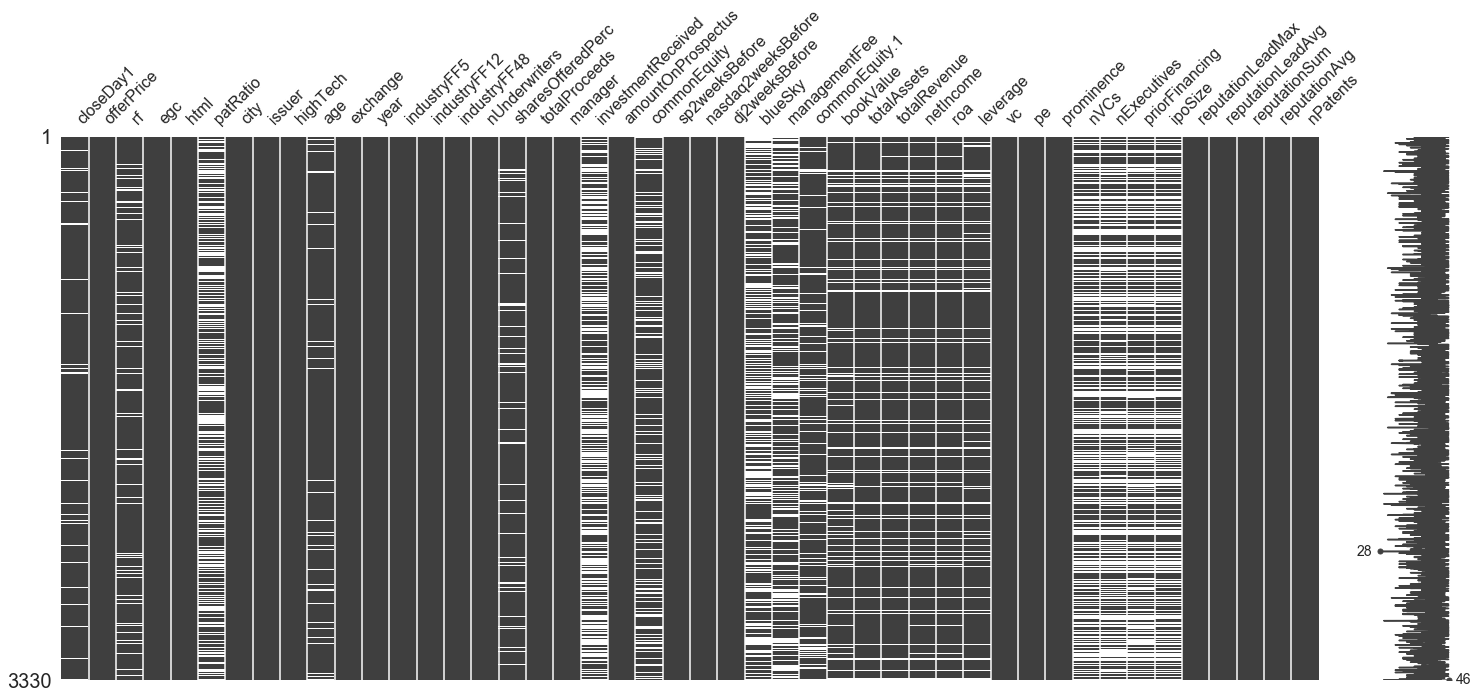

In [20]:
msno.matrix(data)

**Comment** : Write what the following cell does

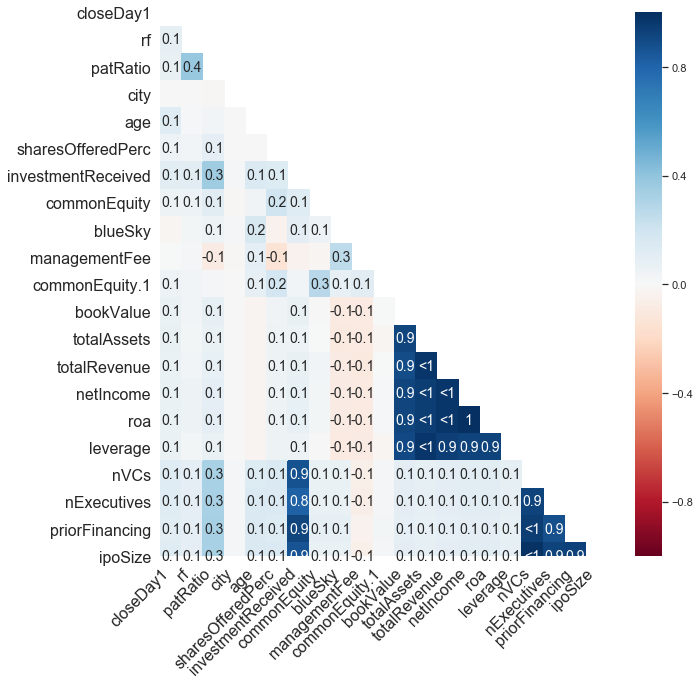

In [21]:
incomplete = data.columns[data.isnull().any()].tolist()
msno.heatmap(data[incomplete], figsize=(10,10))

**Comment**: The following cell shows the correlation among the datafields.

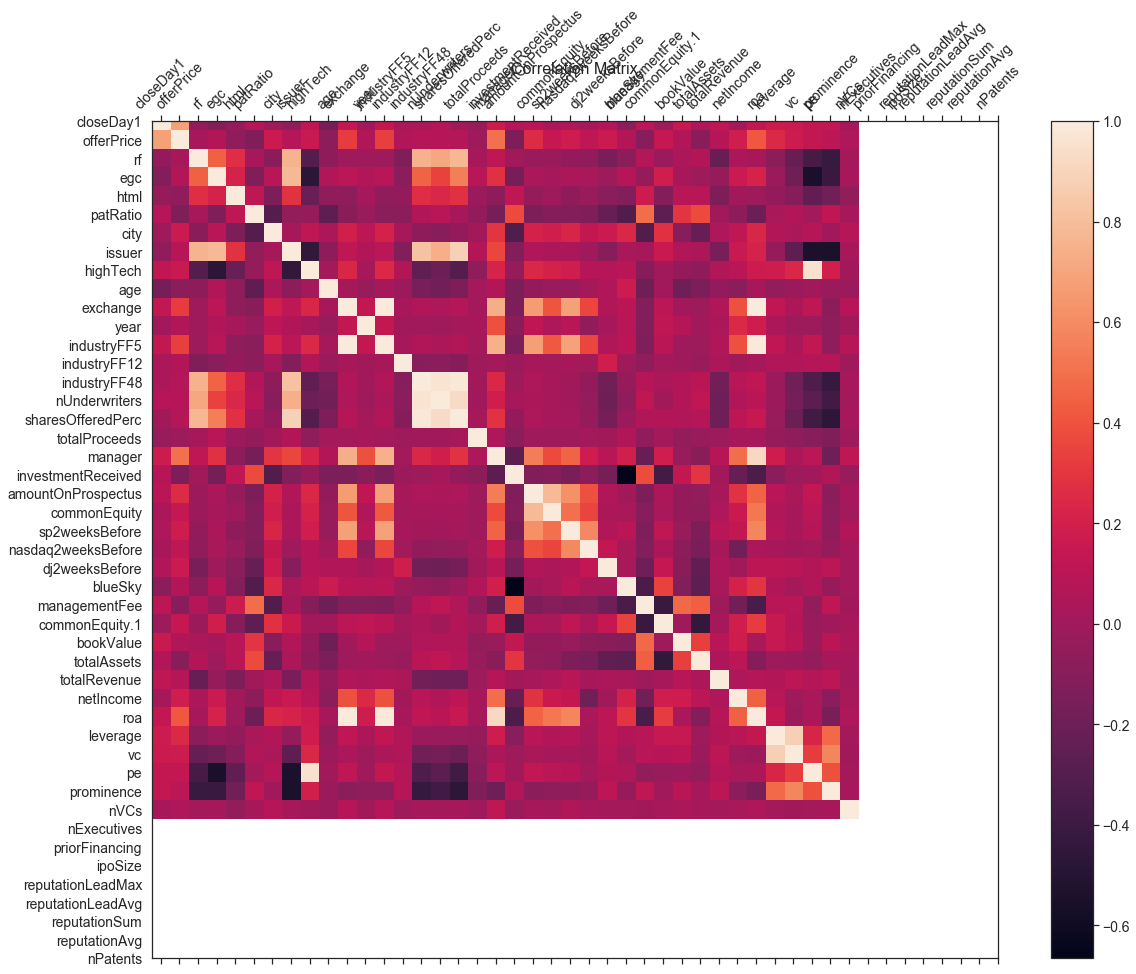

In [22]:
#Plot correlation matrix
f = plt.figure(figsize=(19, 15))
plt.matshow(data.corr(), fignum=f.number)
plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=45)
plt.yticks(range(data.shape[1]), data.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

**Observations**: We notice that most of the fields are weakly correlated. However, there are few features that has strong positive and negative correlations.

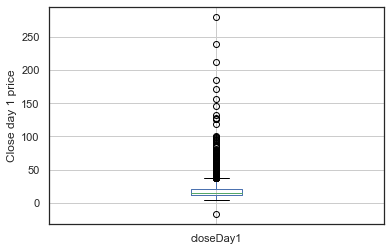

In [23]:
# Distribution of the Close day 1
data.boxplot(column='closeDay1')
plt.ylabel('Close day 1 price')
plt.show()

In [24]:
df_learn['exchange'].value_counts()

NASDQ    2368
NYSE      895
AMEX       67
Name: exchange, dtype: int64

In [25]:
df_learn['industryFF5'].value_counts()

Business Equipment, Telephone and Television Transmission                                         1122
Other                                                                                              898
Healthcare, Medical Equipment, and Drugs                                                           621
Consumer Durables, NonDurables, Wholesale, Retail, and Some Services (Laundries, Repair Shops)     393
Manufacturing, Energy, and Utilities                                                               296
Name: industryFF5, dtype: int64

In [26]:
df_learn['industryFF12'].value_counts().head()

Business Equipment -- Computers, Software, and Electronic Equipment    945
Healthcare, Medical Equipment, and Drugs                               621
Finance                                                                483
Other                                                                  462
Wholesale, Retail, and Some Services (Laundries, Repair Shops)         271
Name: industryFF12, dtype: int64

In [27]:
df_learn['industryFF48'].value_counts().head()

Business Services          845
Pharmaceutical Products    409
Trading                    221
Electronic Equipment       190
Retail                     158
Name: industryFF48, dtype: int64

**Comments**: Will probably need to only keep 1 of these, maybe FF12?


In [28]:
df_learn = df_learn.rename(columns={"commonEquity":"commonEquity1","commonEquity.1":"commonEquity2" })

**Comments**: Age is the age of the firm. Should replace mising values by the mean? Are the zeros indicating new firms?

In [29]:
print(df_learn['age'].mean())
print(df_learn['age'].mode())

16.184561626429478
0    3.0
dtype: float64


In [30]:
len([w for w in df_learn['age'] if w>100])

53

**Comments**: Is it possible to have so much old companies?

In [31]:
print(df_learn['blueSky'].median(), df_learn['blueSky'].mean())

10000.0 12916.115884115885


**Comments**: Should do something with *blue sky* missing value: need to decide if really useful and, if it is, how to fill it. mean, median or mean between 1sr and 3rd quarter

# Part 1: data cleaning and preprocessing


In [32]:
processed_data = copy.deepcopy(df_learn)

## Part 1A : Replacing the null fields
**Comment**: In the following cells, we replace or drop the null fields using appropriate logic for that perticular field

In [33]:
processed_data.replace([np.inf, -np.inf], np.nan, inplace=True)

In [34]:
processed_data['age'].fillna(processed_data['age'].median(), inplace=True)

In [35]:
processed_data['blueSky'].fillna(processed_data['blueSky'].median(), inplace=True)

We decide to drop the data corresponding to missing or negative values of 'closeDay1' as this feature is very important and so replacing missing values may lead to huge misinterpretation. Moreover it corresponds to only 3.5% of the data


In [36]:
processed_data.dropna(subset=["closeDay1"], inplace=True)

**Comment** : We fill the null "Risk factor" field with ""

In [37]:
processed_data.rf.fillna("", inplace=True)

In [38]:
processed_data['patRatio'].fillna(processed_data['patRatio'].median(), inplace=True)

In [39]:
replace_mean = ["sharesOfferedPerc", "investmentReceived", "commonEquity1", "managementFee", "commonEquity2", "bookValue", "totalAssets", "totalRevenue", "netIncome", "roa", "leverage", "priorFinancing", "ipoSize"]

In [40]:
processed_data[replace_mean].head(2)

,sharesOfferedPerc,investmentReceived,commonEquity1,managementFee,commonEquity2,bookValue,totalAssets,totalRevenue,netIncome,roa,leverage,priorFinancing,ipoSize
974,30.50,64190.0,NaN,924417.0,100.00,219.134116,240.974,23.34,-48.811,-0.202557,0.000000,64190.0,68114956.0
2585,17.09,NaN,0.063,NaN,40.99,231.418979,2190.648,142.89,15.918,0.007266,0.155445,NaN,NaN


In [41]:
processed_data[replace_mean] = processed_data[replace_mean].apply(lambda x: x.fillna(x.mean()),axis=0)

In [42]:
processed_data[replace_mean].head(2)

,sharesOfferedPerc,investmentReceived,commonEquity1,managementFee,commonEquity2,bookValue,totalAssets,totalRevenue,netIncome,roa,leverage,priorFinancing,ipoSize
974,30.50,64190.000000,-0.879771,9.244170e+05,100.00,219.134116,240.974,23.34,-48.811,-0.202557,0.000000,64190.00000,6.811496e+07
2585,17.09,172172.815261,0.063000,2.069941e+06,40.99,231.418979,2190.648,142.89,15.918,0.007266,0.155445,130854.10542,1.453785e+08


In [43]:
replace_median = ["nExecutives", "nVCs"]

In [44]:
processed_data[replace_median].head(2)

,nExecutives,nVCs
974,5.0,5.0
2585,NaN,NaN


In [45]:
processed_data[replace_median] = processed_data[replace_median].apply(lambda x: x.fillna(x.median()),axis=0)

In [46]:
processed_data[replace_median].head(2)

,nExecutives,nVCs
974,5.0,5.0
2585,11.0,6.0


In [47]:
processed_data.shape

(3215, 46)

#data.profile_report()

Referring to the profile report generated, attached as HTML along with submission.

We can see that some features are highly correlated, so we will use PCA to remove the redundant features.

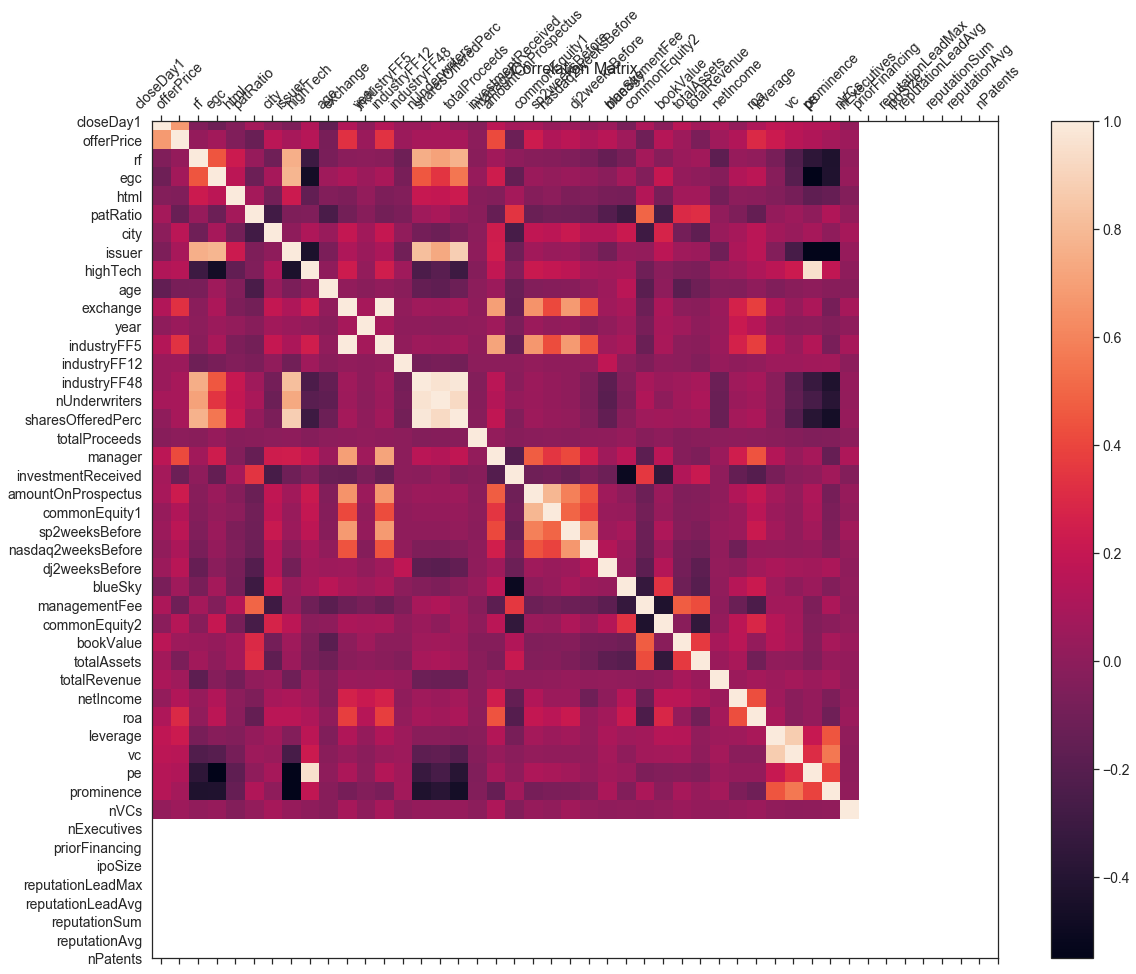

In [48]:
#Plot correlation matrix
f = plt.figure(figsize=(19, 15))
plt.matshow(processed_data.corr(), fignum=f.number)
plt.xticks(range(processed_data.shape[1]), processed_data.columns, fontsize=14, rotation=45)
plt.yticks(range(processed_data.shape[1]), processed_data.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

The following cell shows that all the filed are pre-processed. Since there are no null fields. Also notice that the number of rows have reduced.

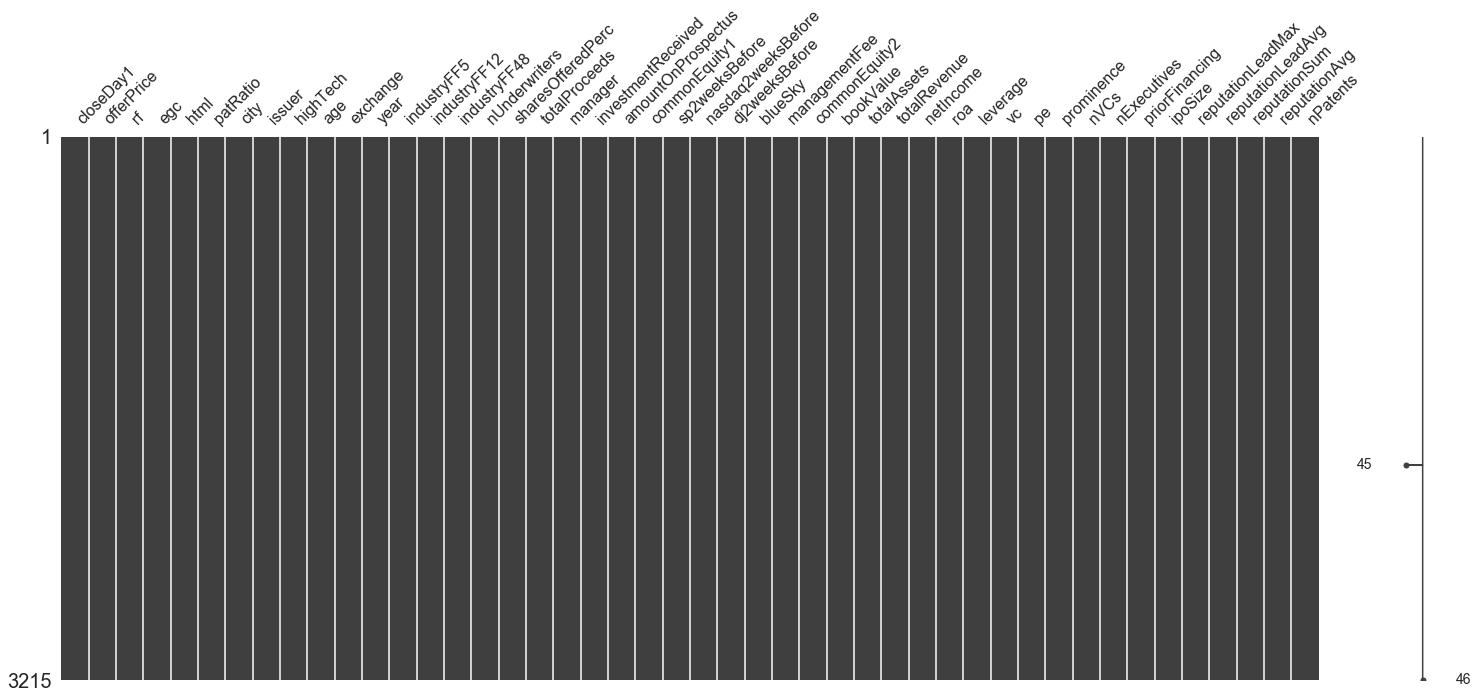

In [49]:
msno.matrix(processed_data)

## Part 1B: Manipulating the fields (Addition, deletion)

**Comments**

1. 'issuer' is unique, hence will not be a useful feature for prediction. We drop it from the list of useful features and set it as index.
2. 'Exchange' is categorical (3 distinct values). We create dummies
3. 'IndustryFF12' is also categorical (5 distinct values)
4. ['manager', 'city'] have high cardinality, hence dropped from the useful features
5. Update True/False fields to 1/0

In [50]:
# Unique field 'issuer' is made index of the cell
processed_data.set_index('issuer', drop=True, inplace=True)

In [51]:
processed_data = pd.get_dummies(data=processed_data, columns= ['exchange', 'industryFF12'])

In [52]:
processed_data.drop(['manager', 'city'], axis=1, inplace=True)

In [53]:
# Creating additional field for return and raisingPrice(upORdown)
processed_data['return'] = (processed_data['closeDay1'] - processed_data['offerPrice'])/(processed_data['offerPrice'] + 1e-10)
processed_data["raisingPrice"] = (processed_data["return"] > 0).astype(int)

Converting all boolean fields to int type (0-False or 1-True)

In [54]:
processed_data[processed_data.select_dtypes([np.bool]).columns] = processed_data.select_dtypes([np.bool]).astype(int)

In [55]:
processed_data['raisingPrice'].shape

(3215,)

In [376]:
processed_data.info(verbose=False, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 3215 entries, Numerical Technologies Inc to Threshold Pharmaceuticals Inc
Columns: 58 entries, closeDay1 to raisingPrice
dtypes: float64(29), int64(11), object(3), uint8(15)
memory usage: 1.3+ MB


In [57]:
#processed_data = processed_data.head(200)

## Part 1C: Text pre-process on Risk Factor

In [58]:
# Get English Stopwords from NLTK & Extend the stop word list
stop_words = stopwords.words('english')
stop_words.extend(['risk', 'factor', 'company', 'stock', 'may', 'inc', 'co', 'result', 'financial', \
               'portfolio', 'business', 'market', 'customer', 'service', 'price', 'management', \
              'product', 'operation', 'adversely', 'new', 'revenue', 'sale', 'operating', \
                   'adverse', 'effect', 'consider', 'careful', 'need', 'cost', 'information', 'investment', \
                   'fact', 'carefully', 'following', 'common'
              ])


In [59]:
print(len(stop_words), stop_words[:10])
''.join(stop_words).__contains__('could')

214 ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


True

In [60]:
#looks how many percent of risk facor are NaN values
processed_data['rf'].isna().sum()/len(processed_data['rf'])

0.0

In [61]:
#file them with a blank
processed_data['rf'] = processed_data['rf'].fillna('')

In [62]:
# Define a custom function to clean some given text
def clean_re(txt):
    txt = re.sub(f"[{string.punctuation}]", "", str(txt))
    
    return txt

In [63]:
# Test clean_re
txt = "akjdf!!@#$%^&*()_/*965214"
clean_re(txt)

'akjdf965214'

In [64]:
# Apply clean_re() to all features
processed_data['rf'] = processed_data['rf'].apply(clean_re)    
processed_data['rf'].head(2)

issuer
Numerical Technologies Inc       RISK FACTORS You should carefully consider the...
Home BancShares Inc,Conway,AR    risk factors an investment in our common stock...
Name: rf, dtype: object

In [65]:
wnl=nltk.stem.WordNetLemmatizer()

def lemmatize_text(txt):
    return ' '.join([wnl.lemmatize(t.lower()) for t in txt.split(' ')])

In [66]:
# Apply lemmatize_text() to all features  
processed_data['rf'] = processed_data['rf'].apply(lemmatize_text)    
processed_data['rf'].head(2)

issuer
Numerical Technologies Inc       risk factor you should carefully consider the ...
Home BancShares Inc,Conway,AR    risk factor an investment in our common stock ...
Name: rf, dtype: object

**Comment**: We notice tht the wordnetlimmatizer doesn't process words such as carefully -> careful, we we wondering about using other nltk tools such as ones shown below. However, the Lancaster Stemmer process words beyond recognition such as creafully-> car, so we decided to go ahead without further processing.

In [67]:
#lnl=nltk.stem.LancasterStemmer()

#def lemmatize_text_lnl(txt):
#    return ' '.join([lnl.stem(t.lower()) for t in txt.split(' ')])

In [68]:
# Apply lemmatize_text() to all features  
#processed_data['rf'] = processed_data['rf'].apply(lemmatize_text_lnl)    
#processed_data['rf'].head(2)

In [69]:
# Define custom function to remove stopwords
def clean_stopwords(txt):
    li = list(txt.lower().split(" "))
    txt = [word for word in li if word not in stop_words]
    return ' '.join(txt)

#pattern = re.compile(r'(?i)\b(' + r'|'.join(stop_words) + r')\b\s*')
#def clean_stopwords(txt):
#    txt = pattern.sub('', txt)
#    return txt 

In [70]:
# Test clean_stopwords
txt = " ".join(stop_words).lower()
print("**All stop words**:", txt)
print("Cleaned text : ", clean_stopwords(txt))

**All stop words**: i me my myself we our ours ourselves you you're you've you'll you'd your yours yourself yourselves he him his himself she she's her hers herself it it's its itself they them their theirs themselves what which who whom this that that'll these those am is are was were be been being have has had having do does did doing a an the and but if or because as until while of at by for with about against between into through during before after above below to from up down in out on off over under again further then once here there when where why how all any both each few more most other some such no nor not only own same so than too very s t can will just don don't should should've now d ll m o re ve y ain aren aren't couldn couldn't didn didn't doesn doesn't hadn hadn't hasn hasn't haven haven't isn isn't ma mightn mightn't mustn mustn't needn needn't shan shan't shouldn shouldn't wasn wasn't weren weren't won won't wouldn wouldn't risk factor company stock may inc co result 

In [71]:
# Apply function to remove stopwords
processed_data['rf'] = processed_data['rf'].apply(clean_stopwords)    
processed_data['rf'].head(2)

issuer
Numerical Technologies Inc       contained prospectus purchasing key within sem...
Home BancShares Inc,Conway,AR    involves making decision described together co...
Name: rf, dtype: object

In [72]:
# Define custom function to wrap simple_preprocess() from gensim
#def sp(txt):
#    return simple_preprocess(txt)

# Define custom function to wrap simple_preprocess() from gensim
def wrap_simple_preprocess(txt):
    return simple_preprocess(str(txt))

In [73]:
# Apply simple_preprocess() to all features
processed_data['rf'] = processed_data['rf'].apply(wrap_simple_preprocess)    
processed_data['rf'].head(2)

issuer
Numerical Technologies Inc       [contained, prospectus, purchasing, key, withi...
Home BancShares Inc,Conway,AR    [involves, making, decision, described, togeth...
Name: rf, dtype: object

# Part 2: Feature extraction

Extract features from the processed data for training the models

## Part 2A: Extracting features from 'rf'

In this section, we utilize NLP to process risk factors and extract useful features for prediction.
Reference: [web link](https://markroxor.github.io/gensim/static/notebooks/gensim_news_classification.html)

### Topic models

We try various topic models (LSI, HDA, LDA) and select one of them based on the coherence score.

In [411]:
id2word = corpora.Dictionary(processed_data['rf'])
corpus = [id2word.doc2bow(doc) for doc in processed_data['rf']]

TypeError: doc2bow expects an array of unicode tokens on input, not a single string

### Extracting feature vector for each observation

In [377]:
selected_topic_model = LdaModel.load('lda_model.model')

In [378]:
rows = processed_data.rf.shape[0]
rows

3215

In [379]:
features_rf = []
for i in range(rows):
    top_topics = selected_topic_model.get_document_topics(corpus[i], minimum_probability=0.0)
    #top_topics = hdp_model.evaluate_test_corpus([corpus[i]])
    topic_vec = [top_topics[i][1] for i in range(int(no_topics_selected))]
    #topic_vec.extend([len(processed_data["rf"].iloc[i])])
    #topic_vec.extend([len(''.join(processed_data["rf"].iloc[i]))]) # length review
    features_rf.append(topic_vec)

In [380]:
df_rf_features = pd.DataFrame(features_rf, columns=range(int(no_topics_selected)), index=processed_data.rf.index).add_prefix('rf_')
pd.concat([df_rf_features, df_rf_features.sum(axis=1)], axis=1).head(3)

,rf_0,rf_1,rf_2,rf_3,0
issuer,,,,,
Numerical Technologies Inc,0.645222,0.000211,0.003276,0.351292,1.0
"Home BancShares Inc,Conway,AR",0.266250,0.730425,0.000250,0.003075,1.0
Boise Cascade Co,0.209174,0.573400,0.000438,0.216988,1.0


In [91]:
#lsi_model = LsiModel(corpus=corpus, num_topics=25, id2word=id2word)
#lsi_model.show_topics(num_topics=3)

In [92]:
#lsi_topics = lsi_model.show_topics(formatted=False)

## Part 2B: Feature selection from processed_data

Extract features and targets from the processed_data

In [93]:
# Select targets 
y_data_labels = ['closeDay1', 'return', 'raisingPrice']
Y_data = processed_data[y_data_labels]

X_data = processed_data.drop(y_data_labels, axis=1)
Y_data.columns, X_data.columns

(Index(['closeDay1', 'return', 'raisingPrice'], dtype='object'),
 Index(['offerPrice', 'rf', 'egc', 'html', 'patRatio', 'highTech', 'age',
        'year', 'industryFF5', 'industryFF48', 'nUnderwriters',
        'sharesOfferedPerc', 'totalProceeds', 'investmentReceived',
        'amountOnProspectus', 'commonEquity1', 'sp2weeksBefore',
        'nasdaq2weeksBefore', 'dj2weeksBefore', 'blueSky', 'managementFee',
        'commonEquity2', 'bookValue', 'totalAssets', 'totalRevenue',
        'netIncome', 'roa', 'leverage', 'vc', 'pe', 'prominence', 'nVCs',
        'nExecutives', 'priorFinancing', 'ipoSize', 'reputationLeadMax',
        'reputationLeadAvg', 'reputationSum', 'reputationAvg', 'nPatents',
        'exchange_AMEX', 'exchange_NASDQ', 'exchange_NYSE',
        'industryFF12_Business Equipment -- Computers, Software, and Electronic Equipment',
        'industryFF12_Chemicals and Allied Products',
        'industryFF12_Consumer Durables -- Cars, TV's, Furniture, Household Appliances',
  

In [94]:
Y_data.head(3)

,closeDay1,return,raisingPrice
issuer,,,
Numerical Technologies Inc,35.5625,1.540179,1
"Home BancShares Inc,Conway,AR",20.0000,0.111111,1
Boise Cascade Co,26.1500,0.245238,1


We drop the text fields 'rf', 'industryFF12', 'industryFF48' and replace them the extracted features using text analysis for 'rf'

In [95]:
X_data.drop(['rf', 'industryFF5', 'industryFF48'], axis=1, inplace=True)

In [96]:
X = pd.concat([X_data, df_rf_features], axis=1, sort=False)

In [97]:
X.head(2)

,offerPrice,egc,html,patRatio,highTech,age,year,nUnderwriters,sharesOfferedPerc,totalProceeds,...,"industryFF12_Manufacturing -- Machinery, Trucks, Planes, Off Furn, Paper, Com Printing","industryFF12_Oil, Gas, and Coal Extraction and Products",industryFF12_Other,industryFF12_Telephone and Television Transmission,industryFF12_Utilities,"industryFF12_Wholesale, Retail, and Some Services (Laundries, Repair Shops)",rf_0,rf_1,rf_2,rf_3
issuer,,,,,,,,,,,,,,,,,,,,,
Numerical Technologies Inc,14.0,0,0,0.492063,1,5.0,2000,14,30.50,68114956,...,0,0,0,0,0,0,0.684771,0.000211,0.003872,0.311147
"Home BancShares Inc,Conway,AR",18.0,0,1,0.447917,0,8.0,2006,4,17.09,45000000,...,0,0,0,0,0,0,0.261852,0.734879,0.000250,0.003019


In [98]:
X_data.head(2)

,offerPrice,egc,html,patRatio,highTech,age,year,nUnderwriters,sharesOfferedPerc,totalProceeds,...,"industryFF12_Consumer Durables -- Cars, TV's, Furniture, Household Appliances","industryFF12_Consumer NonDurables -- Food, Tobacco, Textiles, Apparel, Leather, Toys",industryFF12_Finance,"industryFF12_Healthcare, Medical Equipment, and Drugs","industryFF12_Manufacturing -- Machinery, Trucks, Planes, Off Furn, Paper, Com Printing","industryFF12_Oil, Gas, and Coal Extraction and Products",industryFF12_Other,industryFF12_Telephone and Television Transmission,industryFF12_Utilities,"industryFF12_Wholesale, Retail, and Some Services (Laundries, Repair Shops)"
issuer,,,,,,,,,,,,,,,,,,,,,
Numerical Technologies Inc,14.0,0,0,0.492063,1,5.0,2000,14,30.50,68114956,...,0,0,0,0,0,0,0,0,0,0
"Home BancShares Inc,Conway,AR",18.0,0,1,0.447917,0,8.0,2006,4,17.09,45000000,...,0,0,1,0,0,0,0,0,0,0


### Feature selection for various predictors (P1 o P9)

**Comment**: Select features for Prediction 1 and look at the target variable distribution

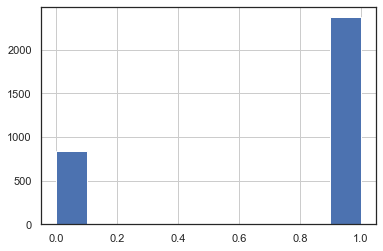

In [99]:
# X_data has all features except 'rf'
X_P1, y_P1 = X_data, Y_data.raisingPrice
assert(X_P1.shape[0] == y_P1.shape[0])
y_P1.hist()

**Comment**: Select features for Prediction 2 and look at the target variable distribution

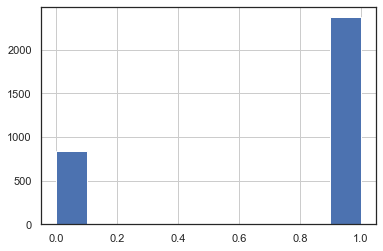

In [100]:
# Data frame X contains all numeric features including extracted features from 'rf'
X_P2, y_P2 = X.filter(regex=("(rf_*)|(FF12_*)|(year)")), Y_data.raisingPrice
assert(X_P2.shape[0] == y_P2.shape[0])
y_P2.hist()

**Comment**: Select features for Prediction 3 and look at the target variable distribution. We select all the available features for predictions from P3 to P9, reduce the dimention using PCA so that features that are not relevent are filtered.

((3215, 56), <matplotlib.axes._subplots.AxesSubplot at 0x7fce1a565438>)

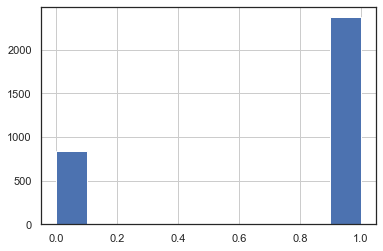

In [101]:
y_P3 = Y_data.raisingPrice
assert(X.shape[0] == y_P3.shape[0])
X.shape, y_P3.hist()

**Comment**: Target variable 'return' distribution

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fce1b358080>]],
      dtype=object)

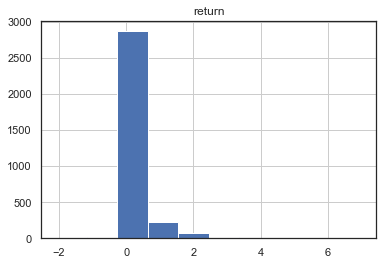

In [102]:
Y_data['return'].reset_index().hist()

**Comment**: Select features for Prediction 4 and look at the target variable distribution

((3215, 56), <matplotlib.axes._subplots.AxesSubplot at 0x7fce1b2ea710>)

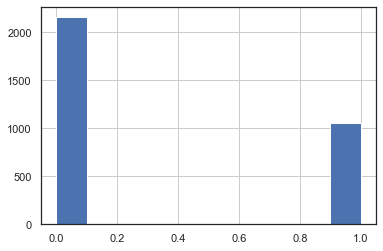

In [103]:
y_P4 = (Y_data['return'] > 0.20).astype('int')
assert(X.shape[0] == y_P4.shape[0])
X.shape, y_P4.hist()

**Comment**: Select features for Prediction 5 and look at the target variable distribution

((3215, 56), <matplotlib.axes._subplots.AxesSubplot at 0x7fce1be442b0>)

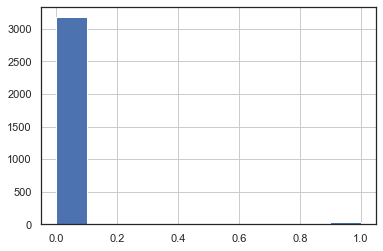

In [104]:
y_P5 = (Y_data['return'] < -0.20).astype('int')
assert(X.shape[0] == y_P5.shape[0])
X.shape, y_P5.hist()

**Comment**: Select features for Prediction 6 and look at the target variable distribution

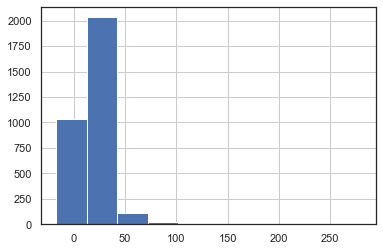

In [105]:
y_P6 = Y_data['closeDay1']
assert(X.shape[0] == y_P6.shape[0])
y_P6.hist()

**Comment**: Select features for Prediction 7 and look at the target variable distribution

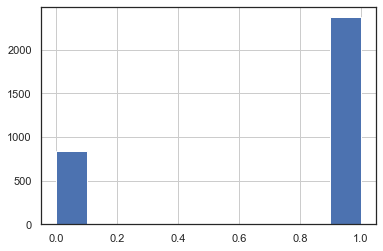

In [106]:
y_P7 = Y_data.raisingPrice
assert(X.shape[0] == y_P7.shape[0])
y_P7.hist()

**Comment**: Select features for Prediction 8 and look at the target variable distribution

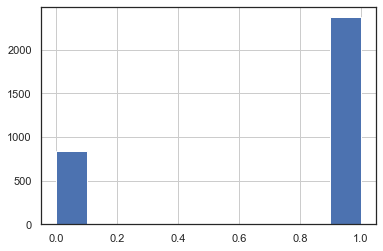

In [107]:
y_P8 = Y_data.raisingPrice
assert(X.shape[0] == y_P8.shape[0])
y_P8.hist()

**Comment**: Select features for Prediction 9 and look at the target variable distribution

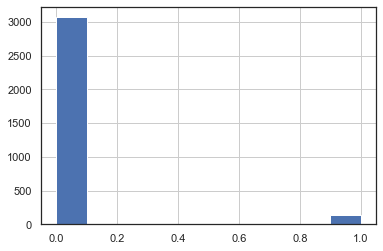

In [108]:
y_P9 = (Y_data['return'] < -0.10).astype('int')
assert(X.shape[0] == y_P9.shape[0])
y_P9.hist()

# Part 3: Feature reduction

Reduce features using PCA, select numeric fields for PCA

# Part 4: Training, tuning, and testing of each model

### Steps in training the model and selection of best hyper parameters
0. Spit the dataset in to traing and testing sets
1. Create pipeline for the respective model
2. Select parameters grid for the respective model
3. Create cross validation scheme
4. Search for the best estimator using Grid search using the train dataset
5. Find the best estimator for given feature and target set using the train dataset
6. Test the best estimator performance using test dataset

**Manual cross check of the best estimator**: We evaluate the model obtained from gridSearch manually and verify the performance before using it for the predictions in Part-5.

In [381]:
no_pca_components_selected=20
scoring_metric = 'roc_auc'
scaling_metric = StandardScaler()
pca_final = PCA(n_components=no_pca_components_selected)
n_cv_splits = 3
scoring_metric_regression = 'r2'

## 1. Random guessing model

In [118]:
# Pipeline
estimators = []
estimators.append(('standardize', scaling_metric))         # standardize features
estimators.append(('model', DummyClassifier(strategy='constant', constant=np.random.choice([0, 1]), random_state=SEED)))
pipeline = Pipeline(estimators)

# Create parameter grid
param_grid = {}

# Select cross validation scheme
cv = StratifiedKFold(n_splits=n_cv_splits, shuffle=False, random_state=SEED)

# GridSearch
# Scoring options : refer - https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
random_model = GridSearchCV(pipeline, param_grid, scoring=scoring_metric, iid=False, cv=cv, n_jobs=-1, refit=True, verbose=2, return_train_score=True)


## A. Baseline model

In [125]:
# Pipeline
estimators = []
estimators.append(('standardize', scaling_metric))         # tell it to standardize features
estimators.append(('model', DummyClassifier(strategy='most_frequent', random_state=SEED)))  # tell it to use a logit model
pipeline = Pipeline(estimators)

# Create parameter grid
param_grid = {}

# Select cross validation scheme
cv = StratifiedKFold(n_splits=n_cv_splits, shuffle=False, random_state=SEED)

# GridSearch
# Scoring options : refer - https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
baseline_model = GridSearchCV(pipeline, param_grid, scoring=scoring_metric, iid=False, cv=cv, n_jobs=-1, refit=True, verbose=2, return_train_score=True)

## B. Linear model

In [133]:
# Pipeline
estimators = []
estimators.append(('standardize', scaling_metric))         # tell it to standardize features
estimators.append(('model', LinearRegression(fit_intercept=False, n_jobs=-1)))  # tell it to use a logit model
pipeline = Pipeline(estimators)

# Create parameter grid
param_grid = {}

# Select cross validation scheme
cv = StratifiedKFold(n_splits=n_cv_splits, shuffle=False, random_state=SEED)

# GridSearch
# Scoring options : refer - https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
linear_model = GridSearchCV(pipeline, param_grid, scoring=scoring_metric, iid=False, cv=cv, n_jobs=-1, refit=True, verbose=2, return_train_score=True)

### Comments 

The AUC is above the baseline one, as we could have expected. The accuracy is also better than the baseline one. So this model is probably to simple to get very good results but is not so bad.

We can further train the linear probability model for all other predictors (P2 to P9) and select a best estimator for each accordingly. We decided to do this using a custom train_test_function_declared in the beginning. The best fit model for Prediction P2 is given below.

## C. Logit model

In [147]:
# Pipeline
estimators = []
estimators.append(('standardize', scaling_metric))         # tell it to standardize features
estimators.append(('model', LogisticRegression(penalty='l1', n_jobs=-1)))  # tell it to use a logit model
pipeline = Pipeline(estimators)

# Create parameter grid
param_grid = {
    'model__C' : np.logspace(-4, 5, 10),
}

# Select cross validation scheme
cv = StratifiedKFold(n_splits=n_cv_splits, shuffle=False, random_state=SEED)

# GridSearch
# Scoring options : refer - https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
logit_model = GridSearchCV(pipeline, param_grid, scoring=scoring_metric, iid=False, cv=cv, n_jobs=-1, refit=True, verbose=2, return_train_score=True)

### Comments

We get a very high auc for the lasso model: it may be good to use it at least for P1

## D. KNN

In this section, we build the pipeline to classify positive and negetive cases in the given data set

In [163]:
# Pipeline
estimators = []
estimators.append(('standardize', scaling_metric))         # tell it to standardize features
estimators.append(('model', KNeighborsClassifier(n_jobs=-1)))  # tell it to use a logit model
pipeline = Pipeline(estimators)

# Create parameter grid
param_grid = {
    'model__n_neighbors' : range(1, 50, 5),
}

# Select cross validation scheme
cv = StratifiedKFold(n_splits=n_cv_splits, shuffle=False, random_state=SEED)

# GridSearch
# Scoring options : refer - https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
knn_model = GridSearchCV(pipeline, param_grid, scoring=scoring_metric, iid=False, cv=cv, n_jobs=-1, refit=True, verbose=2, return_train_score=True)


## E. Decision trees

In [165]:
# Pipeline
estimators = []
estimators.append(('standardize', scaling_metric))         # tell it to standardize features
estimators.append(('model', DecisionTreeClassifier(random_state=SEED)))  # tell it to use a logit model
pipeline = Pipeline(estimators)

# Create parameter grid
param_grid = {
    'model__max_depth' : range(1, 32, 2),
}

# Select cross validation scheme
cv = StratifiedKFold(n_splits=n_cv_splits, shuffle=False, random_state=SEED)

# GridSearch
# Scoring options : refer - https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
decision_trees_model = GridSearchCV(pipeline, param_grid, scoring=scoring_metric, iid=False, cv=cv, n_jobs=-1, refit=True, verbose=2, return_train_score=True)


## F. Random forests

In [174]:
# Pipeline
estimators = []
estimators.append(('standardize', scaling_metric))         # tell it to standardize features
estimators.append(('model', RandomForestClassifier(n_jobs=-1)))  # tell it to use a logit model
pipeline = Pipeline(estimators)

# Create parameter grid
param_grid = {
    'model__n_estimators' : range(1, 251, 10),
}

# Select cross validation scheme
cv = StratifiedKFold(n_splits=n_cv_splits, shuffle=False, random_state=SEED)

# GridSearch
# Scoring options : refer - https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
random_forests_model = GridSearchCV(pipeline, param_grid, scoring=scoring_metric, iid=False, cv=cv, n_jobs=-1, refit=True, verbose=2, return_train_score=True)


## G. Support Vector Machines Classifier : SVC

Using numeric data and SVC classifier for predicting positive and negatve cases

In [185]:
# Pipeline
estimators = []
estimators.append(('standardize', scaling_metric))         # tell it to standardize features
estimators.append(('model', SVC(probability=True, random_state=SEED)))  # tell it to use a logit model
pipeline = Pipeline(estimators)

# Create parameter grid
param_grid = {
    'model__C' : np.logspace(-2, 3, 5),
    'model__kernel' : ('linear', 'rbf')
}

# Select cross validation scheme
cv = StratifiedKFold(n_splits=n_cv_splits, shuffle=False, random_state=SEED)

# GridSearch
# Scoring options : refer - https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
svc_model = GridSearchCV(pipeline, param_grid, scoring=scoring_metric, iid=False, cv=cv, n_jobs=-1, refit=True, verbose=2, return_train_score=True)


## H. Support Vector Regression

In [ ]:
# Pipeline
estimators = []
estimators.append(('standardize', scaling_metric))         # tell it to standardize features
estimators.append(('model', SVR()))  # tell it to use a logit model
pipeline = Pipeline(estimators)

# Create parameter grid
param_grid = {
    'model__C' : np.logspace(-2, 3, 5),
    'model__kernel' : ('linear', 'rbf')
}

# Select cross validation scheme
cv = StratifiedKFold(n_splits=n_cv_splits, shuffle=False, random_state=SEED)

# GridSearch
# Scoring options : refer - https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
svr_model = GridSearchCV(pipeline, param_grid, scoring=scoring_metric_regression, iid=False, cv=cv, n_jobs=-1, refit=True, verbose=2, return_train_score=True)


## I. Neural net classifier (CNN)

In [187]:
# Pipeline
estimators = []
estimators.append(('standardize', scaling_metric))         # tell it to standardize features
estimators.append(('model', MLPClassifier(solver='lbfgs', random_state=SEED)))
pipeline = Pipeline(estimators)

# Create parameter grid
param_grid = {
    'model__alpha' : np.logspace(-4, 5, 10),
}

# Select cross validation scheme
cv = StratifiedKFold(n_splits=n_cv_splits, shuffle=False, random_state=SEED)

# GridSearch
# Scoring options : refer - https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
cnn_model = GridSearchCV(pipeline, param_grid, scoring=scoring_metric, iid=False, cv=cv, n_jobs=-1, refit=True, verbose=2, return_train_score=True)


# Part 5: Ensembles

Ensemble modeling is a process where multiple diverse base models are used to predict an outcome. ... Even though the ensemble model has multiple base models within the model, it acts and performs as a single model. Most of the practical data science applications utilize ensemble modeling techniques.

In this section, we try ensembles on the above trained baseline estimators and compare the performance for P1

In [193]:
n_estimators = 5
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
X_train, X_test, y_train, y_test = train_test_split(X_P1, y_P1, test_size=0.2,  random_state=SEED)

# Part 6: Prediction

Prediction based on the predict xls features for each of P1 to P9

For each prediction, be sure to also show appropriate evaluation metrics in your Jupyter notebook. Show the standard metrics presented in class, but also the custom metrics given to you for problems 7, 8, and 9.

Commit and push your predictions (along with your final jupyter notebook file) as part of your project repository.

In [241]:
df_predict=pd.read_excel("IPO_data_to_predict.xlsx", index_col=0)

In [242]:
df_predict.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 370 entries, 2750 to 1370
Data columns (total 54 columns):
offerPrice            370 non-null float64
rf                    338 non-null object
egc                   370 non-null bool
html                  370 non-null bool
patRatio              234 non-null float64
city                  369 non-null object
issuer                370 non-null object
highTech              370 non-null bool
age                   343 non-null float64
exchange              370 non-null object
year                  370 non-null int64
industryFF5           370 non-null object
industryFF12          370 non-null object
industryFF48          370 non-null object
nUnderwriters         370 non-null int64
sharesOfferedPerc     329 non-null float64
totalProceeds         370 non-null int64
manager               370 non-null object
investmentReceived    196 non-null float64
amountOnProspectus    370 non-null float64
commonEquity          297 non-null float64
sp2weeksBef

### Process the Prediction data features

Changing the name of the collumn 

In [243]:
df_predict = df_predict.rename(columns={"commonEquity":"commonEquity1","commonEquity.1":"commonEquity2" })

### Replacing the null fields

In [244]:
processed_data_predict = copy.deepcopy(df_predict)

In [245]:
processed_data_predict.replace([np.inf, -np.inf], np.nan, inplace=True)

In [246]:
processed_data_predict['age'].fillna(processed_data_predict['age'].median(), inplace=True)

In [247]:
processed_data_predict['blueSky'].fillna(processed_data_predict['blueSky'].median(), inplace=True)

We fill the null "Risk factor" field with ""

In [248]:
processed_data_predict.rf.fillna(" ", inplace=True)

Also, one city is missing, we will replace it with a blank 

In [249]:
processed_data_predict.city.fillna(" ", inplace=True)

In [250]:
processed_data_predict['patRatio'].fillna(processed_data_predict['patRatio'].median(), inplace=True)

In [251]:
replace_mean = ["sharesOfferedPerc", "investmentReceived", "commonEquity1", "managementFee", "commonEquity2", "bookValue", "totalAssets", "totalRevenue", "netIncome", "roa", "leverage", "priorFinancing", "ipoSize"]

In [252]:
processed_data[replace_mean].head(2)

,sharesOfferedPerc,investmentReceived,commonEquity1,managementFee,commonEquity2,bookValue,totalAssets,totalRevenue,netIncome,roa,leverage,priorFinancing,ipoSize
issuer,,,,,,,,,,,,,
Numerical Technologies Inc,30.50,64190.000000,-0.879771,9.244170e+05,100.00,219.134116,240.974,23.34,-48.811,-0.202557,0.000000,64190.00000,6.811496e+07
"Home BancShares Inc,Conway,AR",17.09,172172.815261,0.063000,2.069941e+06,40.99,231.418979,2190.648,142.89,15.918,0.007266,0.155445,130854.10542,1.453785e+08


In [253]:
processed_data_predict[replace_mean] = processed_data_predict[replace_mean].apply(lambda x: x.fillna(x.mean()),axis=0)

In [254]:
replace_median = ["nExecutives", "nVCs"]

In [255]:
processed_data_predict[replace_median] = processed_data_predict[replace_median].apply(lambda x: x.fillna(x.median()),axis=0)

In [256]:
processed_data_predict.shape

(370, 54)

In [257]:
processed_data_predict.head(2)

,offerPrice,rf,egc,html,patRatio,city,issuer,highTech,age,exchange,...,nPatents,P1,P2,P3,P4,P5,P6,P7,P8,P9
2750,17.0,RISK FACTORS Before you invest in our common s...,False,False,0.131579,SAN JOSE,PCTEL Inc,True,5.0,NASDQ,...,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2551,14.0,,False,True,0.448980,MC,Gaslog Ltd,False,9.0,NYSE,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


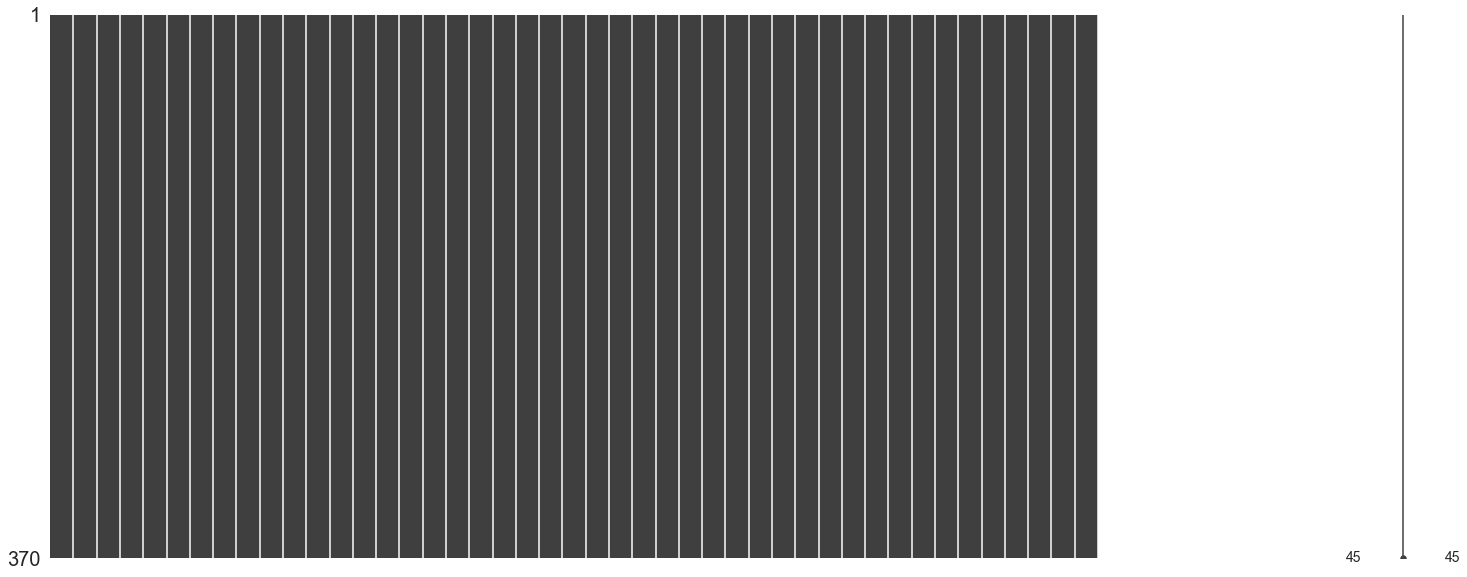

In [258]:
msno.matrix(processed_data_predict)

### Processing the fields (Addition, deletion)

'issuer' is unique, hence will not be a useful feature for prediction. We drop it from the list of useful features and set it as index.

'Exchange' is categorical (3 distinct values). We create dummies

'IndustryFF12' is also categorical (5 distinct values)

['manager', 'city'] have high cardinality, hence dropped from the useful features

Update True/False fields to 1/0

In [259]:
# Unique field 'issuer' is made index of the cell
processed_data_predict.set_index('issuer', drop=True, inplace=True)
processed_data_predict = pd.get_dummies(data=processed_data_predict, columns= ['exchange', 'industryFF12'])
processed_data_predict.drop(['manager', 'city'], axis=1, inplace=True)

In [260]:
processed_data_predict[processed_data_predict.select_dtypes([np.bool]).columns] = processed_data_predict.select_dtypes([np.bool]).astype(int)

We also drop every column P*

In [261]:
processed_data_predict.drop(['P1', 'P2','P3', 'P4','P5', 'P6','P7', 'P8','P9'], axis=1, inplace=True)

In [262]:
processed_data_predict.columns

Index(['offerPrice', 'rf', 'egc', 'html', 'patRatio', 'highTech', 'age',
       'year', 'industryFF5', 'industryFF48', 'nUnderwriters',
       'sharesOfferedPerc', 'totalProceeds', 'investmentReceived',
       'amountOnProspectus', 'commonEquity1', 'sp2weeksBefore',
       'nasdaq2weeksBefore', 'dj2weeksBefore', 'blueSky', 'managementFee',
       'commonEquity2', 'bookValue', 'totalAssets', 'totalRevenue',
       'netIncome', 'roa', 'leverage', 'vc', 'pe', 'prominence', 'nVCs',
       'nExecutives', 'priorFinancing', 'ipoSize', 'reputationLeadMax',
       'reputationLeadAvg', 'reputationSum', 'reputationAvg', 'nPatents',
       'exchange_AMEX', 'exchange_NASDQ', 'exchange_NYSE',
       'industryFF12_Business Equipment -- Computers, Software, and Electronic Equipment',
       'industryFF12_Chemicals and Allied Products',
       'industryFF12_Consumer Durables -- Cars, TV's, Furniture, Household Appliances',
       'industryFF12_Consumer NonDurables -- Food, Tobacco, Textiles, Apparel, L

### Text pre-process on Risk Factor

In [263]:
# Apply clean_re() to all features
processed_data_predict['rf'] = processed_data_predict['rf'].apply(clean_re)    
processed_data_predict['rf'].head(2)

issuer
PCTEL Inc     RISK FACTORS Before you invest in our common s...
Gaslog Ltd                                                     
Name: rf, dtype: object

In [264]:
# Apply lemmatize_text() to all features  
processed_data_predict['rf'] = processed_data_predict['rf'].apply(lemmatize_text)    
processed_data_predict['rf'].head(2)

issuer
PCTEL Inc     risk factor before you invest in our common st...
Gaslog Ltd                                                     
Name: rf, dtype: object

In [265]:
# Apply function to remove stopwords
processed_data_predict['rf'] = processed_data_predict['rf'].apply(clean_stopwords)    
processed_data_predict['rf'].head(2)

issuer
PCTEL Inc     invest various including described together in...
Gaslog Ltd                                                     
Name: rf, dtype: object

In [266]:
# Apply simple_preprocess() to all features
processed_data_predict['rf'] = processed_data_predict['rf'].apply(wrap_simple_preprocess)    
processed_data_predict['rf'].head(2)

issuer
PCTEL Inc     [invest, various, including, described, togeth...
Gaslog Ltd                                                   []
Name: rf, dtype: object

### Extracting features from 'rf'

In [267]:
id2word_predict = corpora.Dictionary(processed_data_predict['rf'])
corpus_predict = [id2word.doc2bow(doc) for doc in processed_data_predict['rf']]

### Extracting feature vector for each observation

In [268]:
rows_predict = processed_data_predict.rf.shape[0]
rows_predict

370

In [269]:
features_rf = []
for i in range(rows_predict):
    top_topics = selected_topic_model.get_document_topics(corpus_predict[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(int(no_topics_selected))]
    features_rf.append(topic_vec)

In [270]:
df_rf_features_pred = pd.DataFrame(features_rf, columns=range(int(no_topics_selected)), index=processed_data_predict.rf.index).add_prefix('rf_')
pd.concat([df_rf_features_pred, df_rf_features_pred.sum(axis=1)], axis=1).head(3)

,rf_0,rf_1,rf_2,rf_3,0
issuer,,,,,
PCTEL Inc,0.254692,0.000204,0.000235,0.744869,1.0
Gaslog Ltd,0.284226,0.212830,0.230207,0.272738,1.0
VIA NET.WORKS Inc,0.827049,0.003076,0.000274,0.169601,1.0


### Feature extraction

In [271]:
X_data_predict = processed_data_predict

In [272]:
#We drop the text fields 'rf', 'industryFF12', 'industryFF48' and add the extracted features using text analysis
X_data_predict.drop(['rf', 'industryFF5', 'industryFF48'], axis=1, inplace=True)
X_predict = pd.concat([X_data_predict, df_rf_features_pred], axis=1, sort=False)

In [273]:
X_predict.head(2)


,offerPrice,egc,html,patRatio,highTech,age,year,nUnderwriters,sharesOfferedPerc,totalProceeds,...,"industryFF12_Manufacturing -- Machinery, Trucks, Planes, Off Furn, Paper, Com Printing","industryFF12_Oil, Gas, and Coal Extraction and Products",industryFF12_Other,industryFF12_Telephone and Television Transmission,industryFF12_Utilities,"industryFF12_Wholesale, Retail, and Some Services (Laundries, Repair Shops)",rf_0,rf_1,rf_2,rf_3
issuer,,,,,,,,,,,,,,,,,,,,,
PCTEL Inc,17.0,0,0,0.131579,1,5.0,1999,13,29.48,78200000,...,0,0,0,0,0,0,0.254692,0.000204,0.000235,0.744869
Gaslog Ltd,14.0,0,1,0.448980,0,9.0,2012,9,37.38,329000000,...,0,0,1,0,0,0,0.284226,0.212830,0.230207,0.272738


In [274]:
incomplete = X_predict.columns[X_predict.isnull().any()].tolist()
incomplete

[]

In [275]:
Xp_P1 = X_data_predict
Xp_P2 = X_predict.filter(regex=("(rf_*)|(FF12_*)|(year)"))
# For all other predictors we use X_predict as the feature

In [276]:
assert(Xp_P1.shape[1] == X_P1.shape[1])

In [277]:
assert(Xp_P2.shape[1] == X_P2.shape[1])

In [278]:
assert(X_predict.shape[1] == X.shape[1])

### Custom function for traing all models for a given training data

In [279]:
def get_best_classifiers(X, y, plot_req=False, test_req=False, scoring='roc_auc', proba=False, pca_req=True):

    if pca_req:
        steps = len(random_model.estimator.steps)
        n_components=pca_final.n_components

        if steps ==2 :
            random_model.estimator.steps.insert(1, ('pca', pca_final))
            linear_model.estimator.steps.insert(1, ('pca', pca_final))
            baseline_model.estimator.steps.insert(1, ('pca', pca_final))
            logit_model.estimator.steps.insert(1, ('pca', pca_final))
            knn_model.estimator.steps.insert(1, ('pca', pca_final))
            decision_trees_model.estimator.steps.insert(1, ('pca', pca_final))
            random_forests_model.estimator.steps.insert(1, ('pca', pca_final))
            svc_model.estimator.steps.insert(1, ('pca', pca_final))
            cnn_model.estimator.steps.insert(1, ('pca', pca_final))

        n_components = min(X.shape[1], n_components)
        random_model.estimator.set_params(pca__n_components=n_components)
        baseline_model.estimator.set_params(pca__n_components=n_components)
        linear_model.estimator.set_params(pca__n_components=n_components)
        logit_model.estimator.set_params(pca__n_components=n_components)
        knn_model.estimator.set_params(pca__n_components=n_components)
        decision_trees_model.estimator.set_params(pca__n_components=n_components)
        random_forests_model.estimator.set_params(pca__n_components=n_components)
        svc_model.estimator.set_params(pca__n_components=n_components)
        cnn_model.estimator.set_params(pca__n_components=n_components)
    
    # Update scoring metric for each of the pipelines
    random_model.scoring = scoring
    linear_model.scoring = scoring
    baseline_model.scoring = scoring
    logit_model.scoring = scoring
    knn_model.scoring = scoring
    decision_trees_model.scoring = scoring
    random_forests_model.scoring = scoring
    svc_model.scoring = scoring
    #svr_model.scoring = scoring
    cnn_model.scoring = scoring
    
    # Train each of the models
    if not proba :
        random_model_final = custom_train_test_function(random_model, X, y, name="Random model", proba=False, custom_test=False, test_req=test_req, plot_train_score=plot_req)
        linear_model_final = custom_train_test_function(linear_model, X, y, name="Linear model", proba=False, custom_test=False, test_req=test_req, plot_train_score=plot_req)
        baseline_model_final = custom_train_test_function(baseline_model, X, y, name="Baseline model", proba=False, custom_test=False, test_req=test_req, plot_train_score=plot_req)

    logit_model_final = custom_train_test_function(logit_model, X, y, name="Logit model", proba=True, custom_test=False, test_req=test_req, plot_train_score=plot_req)
    knn_model_final = custom_train_test_function(knn_model, X, y, name="KNN model", proba=True, custom_test=False, test_req=test_req, plot_train_score=plot_req)
    decision_trees_model_final = custom_train_test_function(decision_trees_model, X, y, name="Decision trees model", proba=True, custom_test=False, test_req=test_req, plot_train_score=plot_req)
    random_forests_model_final = custom_train_test_function(random_forests_model, X, y, name="Random forests model", proba=True, custom_test=False, test_req=test_req, plot_train_score=plot_req)
    #svc_model_final = custom_train_test_function(svc_model, X, y, name="SVC model", proba=True, custom_test=False, test_req=test_req, plot_train_score=plot_req)
    #svr_model_final = custom_train_test_function(svr_model, X, y, name="SVR model", proba=True, custom_test=False, test_req=test_req, plot_train_score=plot_req)
    cnn_model_final = custom_train_test_function(cnn_model, X, y, name="CNN model", proba=True, custom_test=False, test_req=test_req, plot_train_score=plot_req)
    
    if not proba:
        return [random_model_final, baseline_model_final, linear_model_final, logit_model_final, knn_model_final, decision_trees_model_final, random_forests_model_final, cnn_model_final]
    else :
        return [logit_model_final, knn_model_final, decision_trees_model_final, random_forests_model_final, cnn_model_final]

In [280]:
#def get_best_regressors(X, y, plot_req=False, test_req=False):
#    svr_model_final = custom_train_test_function(svr_model, X, y, name="SVR model", proba=True, custom_test=False, test_req=test_req, plot_train_score=plot_req)
    
#    return [svr_model_final]


In [281]:
def test_final_models(models, X_test, y_test, greater_the_better=True):
    results = []
    index = []
    for model in models:
        score = model.score(X_test, y_test)
        name = f"{model.best_estimator_.named_steps['model'].__str__().split('(')[0]}"
        if name in index:
            name = name + '-1'
        index.append(name)
        #print(name, score)
        results.append((score, model))

    results = pd.DataFrame(results, index=index, columns=[scoring_metric, 'model'])#, index=range(len(P1_models)))
    results.sort_values(by=scoring_metric, ascending=(not greater_the_better), inplace=True)
    model_final = results.iloc[0]['model']
    results[[scoring_metric]]
    
    return model_final, results

In [282]:
custom_scorer_P7P8 = make_scorer(custom_scoring_metric_P7P8, greater_is_better=False, needs_proba=True)

In [354]:
custom_scorer_P9 = make_scorer(custom_scoring_metric_P9, greater_is_better=False, needs_proba=True)

## Prediction P1

    Predict whether the closing price at the end of the first day of trading will go up (the "positive" case, coded as 1) or down (the "negative" case, coded as 0) from the offer price. You may use all data from the dataset except for the rf variable (i.e., risk factors).


In [284]:
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
X_train, X_test, y_train, y_test = train_test_split(X_P1, y_P1, test_size=0.2,  random_state=SEED)

In [285]:
# Pipeline
P1_models = get_best_classifiers(X_train, y_train, scoring=scoring_metric)

===============... Training the Random model...===============
Fitting 3 folds for each of 1 candidates, totalling 3 fits

Best parameter (CV score =0.500):
{}
===============... Training the Linear model...===============
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished



Best parameter (CV score =0.655):
{}
===============... Training the Baseline model...===============
Fitting 3 folds for each of 1 candidates, totalling 3 fits

Best parameter (CV score =0.500):
{}
===============... Training the Logit model...===============
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  30 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



Best parameter (CV score =0.654):
{'model__C': 10000.0}
===============... Training the KNN model...===============
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



Best parameter (CV score =0.640):
{'model__n_neighbors': 46}
===============... Training the Decision trees model...===============
Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



Best parameter (CV score =0.610):
{'model__max_depth': 5}
===============... Training the Random forests model...===============
Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   31.1s finished



Best parameter (CV score =0.646):
{'model__n_estimators': 201}
===============... Training the CNN model...===============
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   10.5s finished



Best parameter (CV score =0.664):
{'model__alpha': 10.0}


### Test the trained models on test dataset

In [286]:
P1_model_final, P1_test_results = test_final_models(P1_models, X_test, y_test)
P1_test_results[[scoring_metric]]

,roc_auc
MLPClassifier,0.656434
LogisticRegression,0.636854
KNeighborsClassifier,0.635672
LinearRegression,0.635072
RandomForestClassifier,0.623348
DecisionTreeClassifier,0.590135
DummyClassifier,0.500000
DummyClassifier-1,0.500000


In [287]:
P1_model_final = P1_model_final.fit(X_P1, y_P1)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   14.3s finished



===============ROC curve on the Test data ...===============



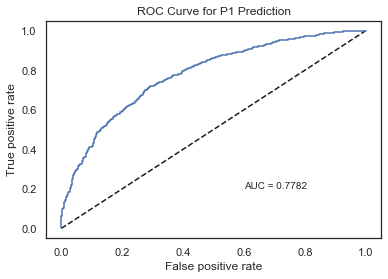

In [288]:
P1_auc = custom_test_function(P1_model_final, X_P1, y_P1, proba=True, name="P1 Prediction")

Test the best base estimator performance with bagging classifier


===============ROC curve on the Test data ...===============



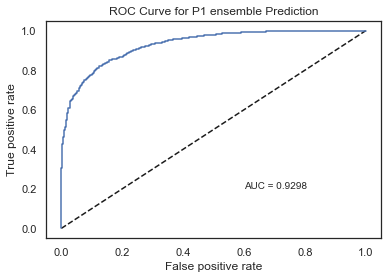

(0.7781619826372103, 0.9298001167128613)

In [289]:
P1_ensemble_model = BaggingClassifier(P1_model_final, n_estimators=n_estimators, n_jobs=-1, random_state=SEED)
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
P1_ensemble_model = P1_ensemble_model.fit(X_P1, y_P1)
P1_auc_en = custom_test_function(P1_ensemble_model, X_P1, y_P1, proba=True, name="P1 ensemble Prediction")
P1_auc, P1_auc_en

Using bagging classifier for P1 ... 


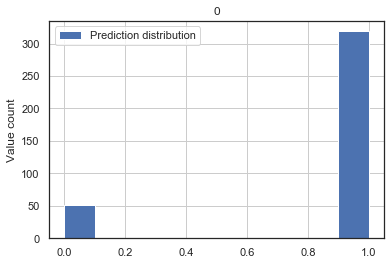

In [290]:
if P1_auc_en > P1_auc:
    print("Using bagging classifier for P1 ... ")
    P1_model_final = P1_ensemble_model 
else :
    print("Using the model without ensembling ...")

yhat_P1 = P1_model_final.predict(Xp_P1)
P1 = pd.DataFrame(yhat_P1, index=df_predict.index)
P1.hist(label="Prediction distribution"), plt.legend(), plt.ylabel('Value count')

df_predict.P1 = P1

## Prediction P2

    Predict whether the closing price at the end of the first day of trading will go up (the "positive" case, coded as 1) or down (the "negative" case, coded as 0) from the offer price. You may use only the rf (i.e., risk factors), year, and industryFF12 variables for this prediction task. You may, however, perform additional text analysis of the rf variable.


In [291]:
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
X_train, X_test, y_train, y_test = train_test_split(X_P2, y_P2, test_size=0.2,  random_state=SEED)

In [292]:
# Pipeline
P2_models = get_best_classifiers(X_train, y_train, scoring=scoring_metric)

===============... Training the Random model...===============
Fitting 3 folds for each of 1 candidates, totalling 3 fits

Best parameter (CV score =0.500):
{}
===============... Training the Linear model...===============
Fitting 3 folds for each of 1 candidates, totalling 3 fits

Best parameter (CV score =0.600):
{}
===============... Training the Baseline model...===============
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  30 | elapsed:    0.1s remaining:    0.5s



Best parameter (CV score =0.500):
{}
===============... Training the Logit model...===============
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



Best parameter (CV score =0.601):
{'model__C': 0.1}
===============... Training the KNN model...===============
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



Best parameter (CV score =0.584):
{'model__n_neighbors': 16}
===============... Training the Decision trees model...===============
Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



Best parameter (CV score =0.578):
{'model__max_depth': 3}
===============... Training the Random forests model...===============
Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   28.5s finished



Best parameter (CV score =0.562):
{'model__n_estimators': 51}
===============... Training the CNN model...===============
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    9.1s finished



Best parameter (CV score =0.602):
{'model__alpha': 100.0}


### Test the trained models on test dataset

In [293]:
P2_model_final, P2_test_results = test_final_models(P2_models, X_test, y_test)
P2_test_results[[scoring_metric]]

,roc_auc
LogisticRegression,0.600289
MLPClassifier,0.598397
LinearRegression,0.597173
DecisionTreeClassifier,0.584085
RandomForestClassifier,0.572652
KNeighborsClassifier,0.570858
DummyClassifier,0.500000
DummyClassifier-1,0.500000


### Retrain the final model on entire dataset and check the performance

In [294]:
P2_model_final = P2_model_final.fit(X_P2, y_P2)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.5s finished



===============ROC curve on the Test data ...===============



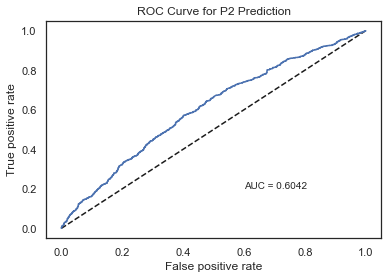

In [295]:
P2_auc = custom_test_function(P2_model_final, X_P2, y_P2, proba=True, name="P2 Prediction")

Test the best base estimator performance with bagging classifier


===============ROC curve on the Test data ...===============



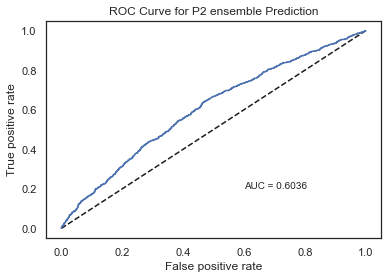

(0.6041699823729546, 0.603596928229598)

In [296]:
P2_ensemble_model = BaggingClassifier(P2_model_final, n_estimators=n_estimators, n_jobs=-1, random_state=SEED)
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
P2_ensemble_model = P2_ensemble_model.fit(X_P2, y_P2)
P2_auc_en = custom_test_function(P2_ensemble_model, X_P2, y_P2, proba=True, name="P2 ensemble Prediction")
P2_auc, P2_auc_en

Using the model without ensembling ...


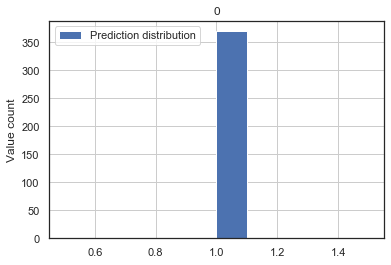

In [297]:
if P2_auc_en > P2_auc:
    print("Using bagging classifier for P2 ... ")
    P2_model_final = P2_ensemble_model 
else :
    print("Using the model without ensembling ...")

yhat_P2 = P2_model_final.predict(Xp_P2)
P2 = pd.DataFrame(yhat_P2, index=df_predict.index)
P2.hist(label="Prediction distribution"), plt.legend(), plt.ylabel('Value count')
plt.show()

df_predict.P2 = P2

For all remaining problems, you may use any or all of the features.

## Prediction P3

    Predict whether the closing price at the end of the first day of trading will go up (the "positive" case, coded as 1) or down (the "negative" case, coded as 0) from the offer price.


In [298]:
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
X_train, X_test, y_train, y_test = train_test_split(X, y_P3, test_size=0.2,  random_state=SEED)

In [299]:
# Pipeline
P3_models = get_best_classifiers(X_train, y_train, scoring=scoring_metric)

===============... Training the Random model...===============
Fitting 3 folds for each of 1 candidates, totalling 3 fits

Best parameter (CV score =0.500):
{}
===============... Training the Linear model...===============
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished



Best parameter (CV score =0.637):
{}
===============... Training the Baseline model...===============
Fitting 3 folds for each of 1 candidates, totalling 3 fits

Best parameter (CV score =0.500):
{}
===============... Training the Logit model...===============
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



Best parameter (CV score =0.648):
{'model__C': 10.0}
===============... Training the KNN model...===============
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



Best parameter (CV score =0.634):
{'model__n_neighbors': 41}
===============... Training the Decision trees model...===============
Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



Best parameter (CV score =0.608):
{'model__max_depth': 5}
===============... Training the Random forests model...===============
Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   28.2s finished



Best parameter (CV score =0.630):
{'model__n_estimators': 221}
===============... Training the CNN model...===============
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   10.0s finished



Best parameter (CV score =0.657):
{'model__alpha': 10.0}


### Test the trained models on test dataset

In [300]:
P3_model_final, P3_test_results = test_final_models(P3_models, X_test, y_test)
P3_test_results[[scoring_metric]]

,roc_auc
MLPClassifier,0.645777
KNeighborsClassifier,0.642886
LogisticRegression,0.639582
RandomForestClassifier,0.638115
LinearRegression,0.637339
DecisionTreeClassifier,0.589389
DummyClassifier,0.500000
DummyClassifier-1,0.500000


### Retrain the final model on entire dataset and check the performance

In [301]:
P3_model_final = P3_model_final.fit(X, y_P3)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   12.6s finished



===============ROC curve on the Test data ...===============



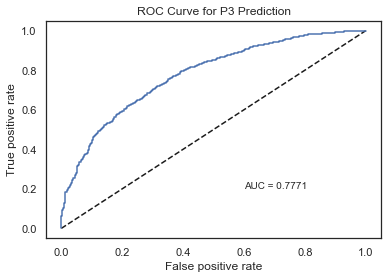

In [302]:
P3_auc = custom_test_function(P3_model_final, X, y_P3, proba=True, name="P3 Prediction")

Test the best base estimator performance with bagging classifier


===============ROC curve on the Test data ...===============



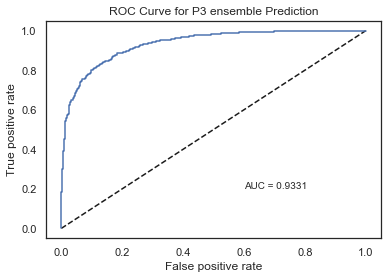

(0.7770869430739525, 0.9330983060619619)

In [303]:
P3_ensemble_model = BaggingClassifier(P3_model_final, n_estimators=n_estimators, n_jobs=-1, random_state=SEED)
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
P3_ensemble_model = P3_ensemble_model.fit(X, y_P3)
P3_auc_en = custom_test_function(P3_ensemble_model, X, y_P3, proba=True, name="P3 ensemble Prediction")
P3_auc, P3_auc_en

Using bagging classifier for P3 ... 


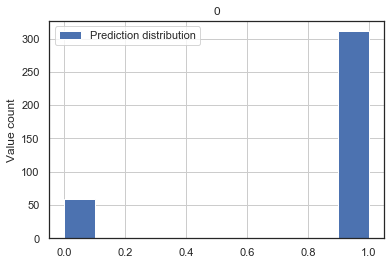

In [304]:
if P3_auc_en > P3_auc:
    print("Using bagging classifier for P3 ... ")
    P3_model_final = P3_ensemble_model 
else :
    print("Using the model without ensembling ...")

yhat_P3 = P3_model_final.predict(X_predict)
P3 = pd.DataFrame(yhat_P3, index=df_predict.index)
P3.hist(label="Prediction distribution"), plt.legend(), plt.ylabel('Value count')
plt.show()

In [305]:
df_predict.P3 = P3

## Prediction P4

    Predict whether the closing price at the end of the first day of trading will go up by more than 20% from the original offer price (the "positive" case, coded as 1) or not (the "negative" case, coded as 0).

In [306]:
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
X_train, X_test, y_train, y_test = train_test_split(X, y_P4, test_size=0.2,  random_state=SEED)

In [307]:
# Pipeline
P4_models = get_best_classifiers(X_train, y_train, scoring=scoring_metric)

===============... Training the Random model...===============
Fitting 3 folds for each of 1 candidates, totalling 3 fits

Best parameter (CV score =0.500):
{}
===============... Training the Linear model...===============
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



Best parameter (CV score =0.759):
{}
===============... Training the Baseline model...===============
Fitting 3 folds for each of 1 candidates, totalling 3 fits

Best parameter (CV score =0.500):
{}
===============... Training the Logit model...===============
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done   7 out of  30 | elapsed:    0.2s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



Best parameter (CV score =0.759):
{'model__C': 1000.0}
===============... Training the KNN model...===============
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



Best parameter (CV score =0.762):
{'model__n_neighbors': 46}
===============... Training the Decision trees model...===============
Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



Best parameter (CV score =0.720):
{'model__max_depth': 5}
===============... Training the Random forests model...===============
Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   25.9s finished



Best parameter (CV score =0.766):
{'model__n_estimators': 171}
===============... Training the CNN model...===============
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   10.0s finished



Best parameter (CV score =0.776):
{'model__alpha': 10.0}


### Test the trained models on test dataset

In [308]:
P4_model_final, P4_test_results = test_final_models(P4_models, X_test, y_test)
P4_test_results[[scoring_metric]]

,roc_auc
MLPClassifier,0.781113
LinearRegression,0.775946
LogisticRegression,0.774585
KNeighborsClassifier,0.773170
RandomForestClassifier,0.769341
DecisionTreeClassifier,0.705119
DummyClassifier,0.500000
DummyClassifier-1,0.500000


### Retrain the final model on entire dataset and check the performance

In [309]:
P4_model_final = P4_model_final.fit(X, y_P4)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   12.9s finished



===============ROC curve on the Test data ...===============



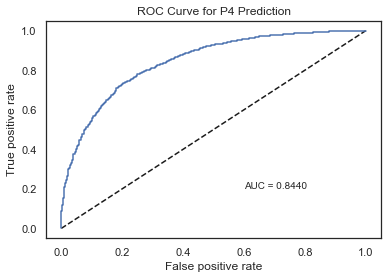

In [310]:
P4_auc = custom_test_function(P4_model_final, X, y_P4, proba=True, name="P4 Prediction")

Test the best base estimator performance with bagging classifier


===============ROC curve on the Test data ...===============



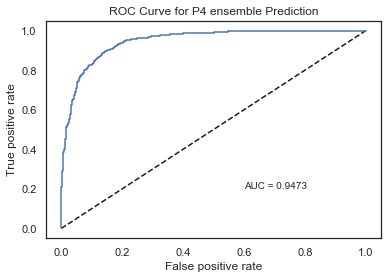

(0.8439570084427661, 0.9473087751632395)

In [311]:
P4_ensemble_model = BaggingClassifier(P4_model_final, n_estimators=n_estimators, n_jobs=-1, random_state=SEED)
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
P4_ensemble_model = P4_ensemble_model.fit(X, y_P4)
P4_auc_en = custom_test_function(P4_ensemble_model, X, y_P4, proba=True, name="P4 ensemble Prediction")
P4_auc, P4_auc_en

Using bagging classifier for P4 ... 


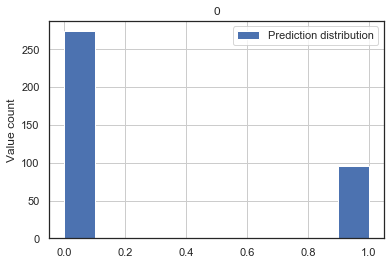

In [312]:
if P4_auc_en > P4_auc:
    print("Using bagging classifier for P4 ... ")
    P4_model_final = P4_ensemble_model 
else :
    print("Using the model without ensembling ...")

yhat_P4 = P4_model_final.predict(X_predict)
P4 = pd.DataFrame(yhat_P4, index=df_predict.index)
P4.hist(label="Prediction distribution"), plt.legend(), plt.ylabel('Value count')
plt.show()

In [313]:
df_predict.P4 = P4

## Prediction P5

    Predict whether the closing price at the end of the first day of trading will go down by more than 20% from the original offer price (the "positive" case, coded as 1) or not (the "negative" case, coded as 0).


In [314]:
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
X_train, X_test, y_train, y_test = train_test_split(X, y_P5, test_size=0.2,  random_state=SEED)

In [315]:
# Pipeline
P5_models = get_best_classifiers(X_train, y_train, scoring=scoring_metric)

===============... Training the Random model...===============
Fitting 3 folds for each of 1 candidates, totalling 3 fits

Best parameter (CV score =0.500):
{}
===============... Training the Linear model...===============
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



Best parameter (CV score =0.720):
{}
===============... Training the Baseline model...===============
Fitting 3 folds for each of 1 candidates, totalling 3 fits

Best parameter (CV score =0.500):
{}
===============... Training the Logit model...===============
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done   7 out of  30 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



Best parameter (CV score =0.746):
{'model__C': 100.0}
===============... Training the KNN model...===============
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



Best parameter (CV score =0.681):
{'model__n_neighbors': 41}
===============... Training the Decision trees model...===============
Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



Best parameter (CV score =0.594):
{'model__max_depth': 1}
===============... Training the Random forests model...===============
Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   19.3s finished



Best parameter (CV score =0.665):
{'model__n_estimators': 41}
===============... Training the CNN model...===============
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    7.9s finished



Best parameter (CV score =0.728):
{'model__alpha': 1.0}


### Test the trained models on test dataset

In [316]:
P5_model_final, P5_test_results = test_final_models(P5_models, X_test, y_test)
P5_test_results[[scoring_metric]]

,roc_auc
LogisticRegression,0.844846
LinearRegression,0.802459
RandomForestClassifier,0.747122
MLPClassifier,0.717164
KNeighborsClassifier,0.646389
DecisionTreeClassifier,0.503401
DummyClassifier,0.500000
DummyClassifier-1,0.500000


### Retrain the final model on entire dataset and check the performance

In [317]:
P5_model_final = P5_model_final.fit(X, y_P5)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.9s finished



===============ROC curve on the Test data ...===============



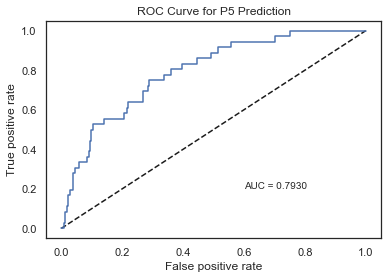

In [318]:
P5_auc = custom_test_function(P5_model_final, X, y_P5, proba=True, name="P5 Prediction")

Test the best base estimator performance with bagging classifier


===============ROC curve on the Test data ...===============



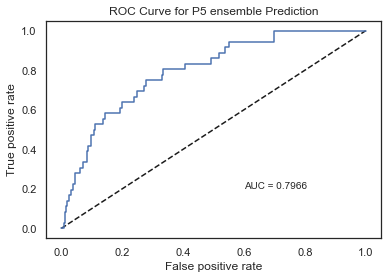

(0.7930341477054279, 0.7966254237880536)

In [319]:
P5_ensemble_model = BaggingClassifier(P5_model_final, n_estimators=n_estimators, n_jobs=-1, random_state=SEED)
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
P5_ensemble_model = P5_ensemble_model.fit(X, y_P5)
P5_auc_en = custom_test_function(P5_ensemble_model, X, y_P5, proba=True, name="P5 ensemble Prediction")
P5_auc, P5_auc_en

Using bagging classifier for P5 ... 


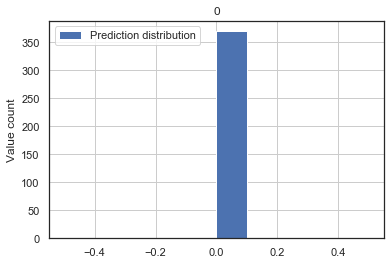

In [320]:
if P5_auc_en > P5_auc:
    print("Using bagging classifier for P5 ... ")
    P5_model_final = P5_ensemble_model 
else :
    print("Using the model without ensembling ...")

yhat_P5 = P5_model_final.predict(X_predict)
P5 = pd.DataFrame(yhat_P5, index=df_predict.index)
P5.hist(label="Prediction distribution"), plt.legend(), plt.ylabel('Value count')
plt.show()

In [321]:
df_predict.P5 = P5

## Prediction P6

    Predict the share price at the end of the first day.


In [322]:
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
X_train, X_test, y_train, y_test = train_test_split(X, y_P8, test_size=0.2,  random_state=SEED)

In [323]:
# Pipeline
P8_models = get_best_classifiers(X_train, y_train, scoring=scoring_metric)

===============... Training the Random model...===============
Fitting 3 folds for each of 1 candidates, totalling 3 fits

Best parameter (CV score =0.500):
{}
===============... Training the Linear model...===============
Fitting 3 folds for each of 1 candidates, totalling 3 fits

Best parameter (CV score =0.639):
{}
===============... Training the Baseline model...===============


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits

Best parameter (CV score =0.500):
{}
===============... Training the Logit model...===============
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  30 | elapsed:    0.2s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



Best parameter (CV score =0.650):
{'model__C': 100000.0}
===============... Training the KNN model...===============
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



Best parameter (CV score =0.632):
{'model__n_neighbors': 46}
===============... Training the Decision trees model...===============
Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



Best parameter (CV score =0.611):
{'model__max_depth': 7}
===============... Training the Random forests model...===============
Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   28.2s finished



Best parameter (CV score =0.630):
{'model__n_estimators': 221}
===============... Training the CNN model...===============
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   10.4s finished



Best parameter (CV score =0.662):
{'model__alpha': 10.0}


In [324]:
### Test the trained models on test dataset

In [325]:
P6_model_final, P6_test_results = test_final_models(P8_models, X_test, y_test)
P6_test_results[[scoring_metric]]

,roc_auc
MLPClassifier,0.660787
LinearRegression,0.642710
LogisticRegression,0.639485
RandomForestClassifier,0.633714
KNeighborsClassifier,0.632459
DecisionTreeClassifier,0.596379
DummyClassifier,0.500000
DummyClassifier-1,0.500000


In [326]:
### Retrain the final model on entire dataset and check the performance

In [328]:
P6_model_final = P6_model_final.fit(X, y_P8)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   16.7s finished



===============ROC curve on the Test data ...===============



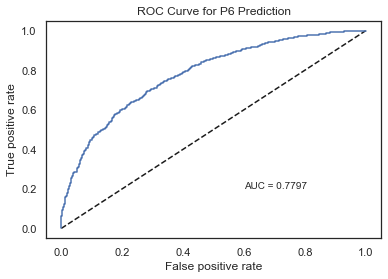

In [329]:
P6_auc = custom_test_function(P6_model_final, X, y_P8, proba=True, name="P6 Prediction")

Test the best base estimator performance with bagging classifier


===============ROC curve on the Test data ...===============



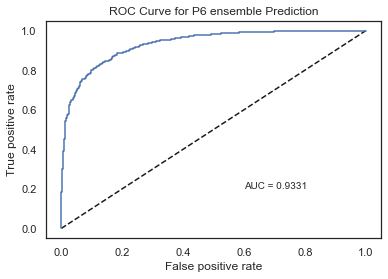

(0.7796914616434092, 0.9330983060619619)

In [330]:
P6_ensemble_model = BaggingClassifier(P6_model_final, n_estimators=n_estimators, n_jobs=-1, random_state=SEED)
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
P6_ensemble_model = P6_ensemble_model.fit(X, y_P8)
P6_auc_en = custom_test_function(P6_ensemble_model, X, y_P8, proba=True, name="P6 ensemble Prediction")
P6_auc, P6_auc_en

Using bagging classifier for P6 ... 


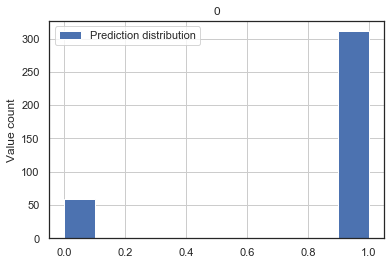

In [331]:
if P6_auc_en > P6_auc:
    print("Using bagging classifier for P6 ... ")
    P6_model_final = P6_ensemble_model 
else :
    print("Using the model without ensembling ...")

yhat_P6 = P6_model_final.predict(X_predict)
P6 = pd.DataFrame(yhat_P6, index=df_predict.index)
P6.hist(label="Prediction distribution"), plt.legend(), plt.ylabel('Value count')
plt.show()

In [332]:
df_predict.P6 = P6

For the remaining problems, provide a predicted probability (expressed as a number from 0 to 100) that the stated event will happen.
## Prediction P7

    Predict the probability that the closing price at the end of the first day of trading will go up by more than 5% from the original offer price.

Scoring Metric for P7: Your predictions will be evaluated in the following manner (where scored points are bad). For every observation, make a predicted probability, p, ranging from 0 to 100. For predictions where the event turns out to be FALSE, a score of p * p (i.e., the square of your predicted probability for that event) will be assessed. For predictions where the event turns out to be TRUE, a score of (100 - p) * (100 - p) will be assessed (i.e., the square of 100 minus your predicted probability for that event). Attempt to tune you prediction model(s) accordingly.

For example: If you predict 70 for an observation that ends up being FALSE, then the score for that observation would equal 4,900 (70 * 70 = 4,900); but if you predict 70 for an observation that ends up being TRUE, then the score for that observation would equal 900 (100 - 70 = 30, and 30 * 30 = 900).

In [333]:
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
X_train, X_test, y_train, y_test = train_test_split(X, y_P7, test_size=0.2,  random_state=SEED)

In [334]:
# Pipeline
P7_models = get_best_classifiers(X_train, y_train, scoring=custom_scorer_P7P8, proba=True)

===============... Training the Logit model...===============
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



Best parameter (CV score =-155.312):
{'model__C': 10000.0}
===============... Training the KNN model...===============
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



Best parameter (CV score =-157.339):
{'model__n_neighbors': 36}
===============... Training the Decision trees model...===============
Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



Best parameter (CV score =-161.034):
{'model__max_depth': 3}
===============... Training the Random forests model...===============
Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   30.1s finished



Best parameter (CV score =-157.482):
{'model__n_estimators': 231}
===============... Training the CNN model...===============
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   10.1s finished



Best parameter (CV score =-154.790):
{'model__alpha': 10.0}


### Test the trained models on test dataset

In [335]:
P7_model_final, P7_test_results = test_final_models(P7_models, X_test, y_test, greater_the_better=True)
P7_test_results[[scoring_metric]]

,roc_auc
MLPClassifier,-122.614032
RandomForestClassifier,-123.653792
KNeighborsClassifier,-123.736883
LogisticRegression,-124.371659
DecisionTreeClassifier,-127.841036


### Retrain the final model on entire dataset and check the performance

In [336]:
P7_model_final = P7_model_final.fit(X, y_P7)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   12.1s finished



===============ROC curve on the Test data ...===============



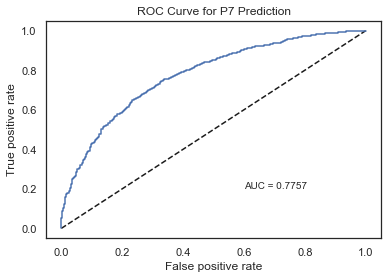

In [337]:
P7_auc = custom_test_function(P7_model_final, X, y_P7, proba=True, name="P7 Prediction")

Test the best base estimator performance with bagging classifier


===============ROC curve on the Test data ...===============



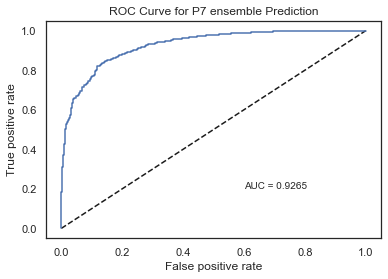

(0.7757341349084566, 0.9264984239759848)

In [338]:
P7_ensemble_model = BaggingClassifier(P7_model_final, n_estimators=n_estimators, n_jobs=-1, random_state=SEED)
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
P7_ensemble_model = P7_ensemble_model.fit(X, y_P7)
P7_auc_en = custom_test_function(P7_ensemble_model, X, y_P7, proba=True, name="P7 ensemble Prediction")
P7_auc, P7_auc_en

Using bagging classifier for P7 ... 


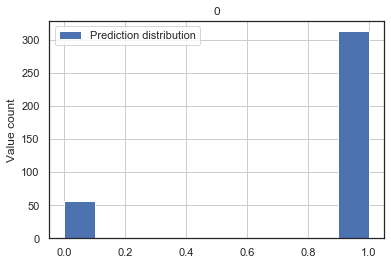

In [339]:
if P7_auc_en > P7_auc:
    print("Using bagging classifier for P7 ... ")
    P7_model_final = P7_ensemble_model 
else :
    print("Using the model without ensembling ...")

yhat_P7 = P7_model_final.predict(X_predict)
P7 = pd.DataFrame(yhat_P7, index=df_predict.index)
P7.hist(label="Prediction distribution"), plt.legend(), plt.ylabel('Value count')
plt.show()

In [340]:
df_predict.P7 = P7

## Prediction P8

    Predict the probability that the closing price at the end of the first day of trading will go up by more than 50% from the original offer price.

Scoring Metric for P8: Same scoring metric as P7 above. Attempt to tune you prediction model(s) accordingly.

In [341]:
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
X_train, X_test, y_train, y_test = train_test_split(X, y_P8, test_size=0.2,  random_state=SEED)

In [343]:
# Pipeline
P8_models = get_best_classifiers(X_train, y_train, scoring=custom_scorer_P7P8, proba=True)

===============... Training the Logit model...===============
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    3.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



Best parameter (CV score =-155.030):
{'model__C': 10000.0}
===============... Training the KNN model...===============
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



Best parameter (CV score =-157.137):
{'model__n_neighbors': 46}
===============... Training the Decision trees model...===============
Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



Best parameter (CV score =-161.153):
{'model__max_depth': 3}
===============... Training the Random forests model...===============
Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   30.2s finished



Best parameter (CV score =-157.656):
{'model__n_estimators': 231}
===============... Training the CNN model...===============
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   10.5s finished



Best parameter (CV score =-155.256):
{'model__alpha': 10.0}


### Test the trained models on test dataset

In [344]:
P8_model_final, P8_test_results = test_final_models(P8_models, X_test, y_test)
P8_test_results[[scoring_metric]]

,roc_auc
KNeighborsClassifier,-123.259452
RandomForestClassifier,-123.843856
MLPClassifier,-123.953349
LogisticRegression,-124.270643
DecisionTreeClassifier,-129.161021


In [345]:
### Retrain the final model on entire dataset and check the performance

In [346]:
P8_model_final = P8_model_final.fit(X, y_P8)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    3.3s finished



===============ROC curve on the Test data ...===============



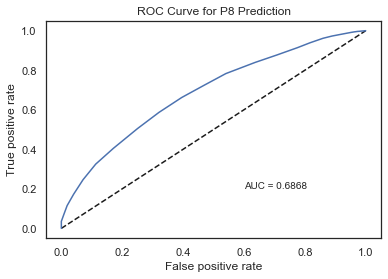

In [347]:
P8_auc = custom_test_function(P8_model_final, X, y_P8, proba=True, name="P8 Prediction")

Test the best base estimator performance with bagging classifier


===============ROC curve on the Test data ...===============



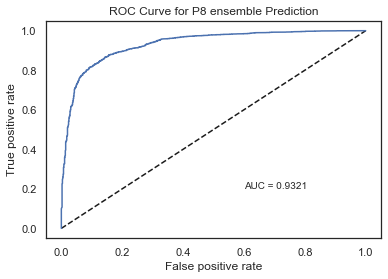

(0.6868236584777481, 0.9320608027963042)

In [348]:
P8_ensemble_model = BaggingClassifier(P8_model_final, n_estimators=n_estimators, n_jobs=-1, random_state=SEED)
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
P8_ensemble_model = P8_ensemble_model.fit(X, y_P8)
P8_auc_en = custom_test_function(P8_ensemble_model, X, y_P8, proba=True, name="P8 ensemble Prediction")
P8_auc, P8_auc_en

Using bagging classifier for P8 ... 


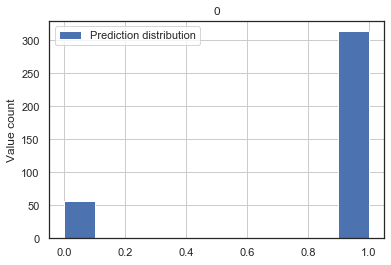

In [349]:
if P8_auc_en > P8_auc:
    print("Using bagging classifier for P8 ... ")
    P8_model_final = P8_ensemble_model 
else :
    print("Using the model without ensembling ...")

yhat_P8 = P8_model_final.predict(X_predict)
P8 = pd.DataFrame(yhat_P8, index=df_predict.index)
P8.hist(label="Prediction distribution"), plt.legend(), plt.ylabel('Value count')
plt.show()

In [350]:
df_predict.P8 = P8

## Prediction P9

    Predict the probability that the closing price at the end of the first day of trading will go down (the "positive" case, coded as 1) or not (coded as 0) by more than 10% from the original offer price.

Scoring Metric for P9: Your predictions will be evaluated in the following manner (where scored points are bad). For every observation, make a predicted probability, p, ranging from 0 to 100. For predictions where the event turns out to be FALSE, a score equal to p will be assessed. For predictions where the event turns out to be TRUE, a score of 2 * (100 - p) will be assessed. Attempt to tune you prediction model(s) accordingly.

For example: If you predict 70 for an observation that ends up being FALSE, the score for that observation would equal 70; but if you predict 70 for an observation that ends up being TRUE, then the score for that observation would equal 2 * (100 - 70) = 60.

In [355]:
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
X_train, X_test, y_train, y_test = train_test_split(X, y_P9, test_size=0.2,  random_state=SEED)

In [356]:
# Pipeline
P9_models = get_best_classifiers(X_train, y_train, scoring=custom_scorer_P9, proba=True)

===============... Training the Logit model...===============
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



Best parameter (CV score =-837.333):
{'model__C': 0.0001}
===============... Training the KNN model...===============
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



Best parameter (CV score =-1560.520):
{'model__n_neighbors': 41}
===============... Training the Decision trees model...===============
Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



Best parameter (CV score =-1541.000):
{'model__max_depth': 31}
===============... Training the Random forests model...===============
Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   29.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



Best parameter (CV score =-1544.667):
{'model__n_estimators': 1}
===============... Training the CNN model...===============
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   11.6s finished



Best parameter (CV score =-1557.812):
{'model__alpha': 0.0001}


### Test the trained models on test dataset

In [357]:
P9_model_final, P9_test_results = test_final_models(P9_models, X_test, y_test)
P9_test_results[[scoring_metric]]

,roc_auc
LogisticRegression,-631.000000
DecisionTreeClassifier,-1173.000000
RandomForestClassifier,-1173.000000
KNeighborsClassifier,-1184.146341
MLPClassifier,-1187.384436


### Retrain the final model on entire dataset and check the performance

In [358]:
P9_model_final = P9_model_final.fit(X, y_P9)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.8s finished



===============ROC curve on the Test data ...===============



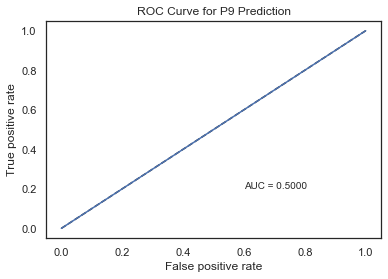

In [359]:
P9_auc = custom_test_function(P9_model_final, X, y_P9, proba=True, name="P9 Prediction")

Test the best base estimator performance with bagging classifier


===============ROC curve on the Test data ...===============



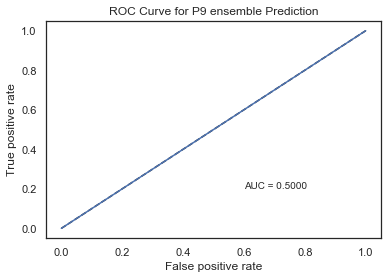

(0.5, 0.5)

In [360]:
P9_ensemble_model = BaggingClassifier(P9_model_final, n_estimators=n_estimators, n_jobs=-1, random_state=SEED)
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
P9_ensemble_model = P9_ensemble_model.fit(X, y_P9)
P9_auc_en = custom_test_function(P9_ensemble_model, X, y_P9, proba=True, name="P9 ensemble Prediction")
P9_auc, P9_auc_en

Using the model without ensembling ...


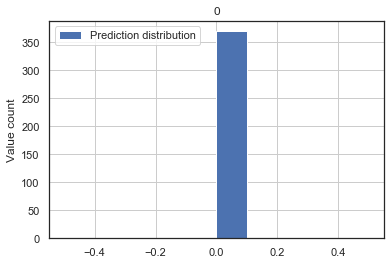

In [361]:
if P9_auc_en > P9_auc:
    print("Using bagging classifier for P9 ... ")
    P9_model_final = P9_ensemble_model 
else :
    print("Using the model without ensembling ...")

yhat_P9 = P9_model_final.predict(X_predict)
P9 = pd.DataFrame(yhat_P9, index=df_predict.index)
P9.hist(label="Prediction distribution"), plt.legend(), plt.ylabel('Value count')
plt.show()

In [362]:
df_predict.P9 = P9

In [363]:
scores = pd.concat([results[[scoring_metric]] for results in [P1_test_results, P2_test_results, P3_test_results, P4_test_results, P4_test_results, P6_test_results, P7_test_results, P8_test_results, P9_test_results]], axis=1).reset_index()
scores.columns = ['Classifier', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9']

In [364]:
scores

,Classifier,P1,P2,P3,P4,P5,P6,P7,P8,P9
0,DecisionTreeClassifier,0.590135,0.584085,0.589389,0.705119,0.705119,0.596379,-127.841036,-129.161021,-1173.000000
1,DummyClassifier,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,NaN,NaN,NaN
2,DummyClassifier-1,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,NaN,NaN,NaN
3,KNeighborsClassifier,0.635672,0.570858,0.642886,0.773170,0.773170,0.632459,-123.736883,-123.259452,-1184.146341
4,LinearRegression,0.635072,0.597173,0.637339,0.775946,0.775946,0.642710,NaN,NaN,NaN
5,LogisticRegression,0.636854,0.600289,0.639582,0.774585,0.774585,0.639485,-124.371659,-124.270643,-631.000000
6,MLPClassifier,0.656434,0.598397,0.645777,0.781113,0.781113,0.660787,-122.614032,-123.953349,-1187.384436
7,RandomForestClassifier,0.623348,0.572652,0.638115,0.769341,0.769341,0.633714,-123.653792,-123.843856,-1173.000000
